In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
import altair as alt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.base import clone

from prettytable import PrettyTable, TableStyle
import joblib


In [82]:
random_state=22   #You can change the random state, set it back to 22 for reproducibility

# Load data and perform train test split

In [83]:
def load_data(option: str = "1985-2023") -> pd.DataFrame:
    df = pd.DataFrame()
    if option == "1985-2023":
        df = pd.read_excel("../dataset/Features_crime_data_1985-2023.xlsx")
        df=df.set_index(["County","Year"])
    if option == "2010-2023":
        df = pd.read_excel("../dataset/Features_crime_data_2010-2023.xlsx")
        df=df.set_index(["County","Year"])
    return df

tentative_df_1985 = load_data()
tentative_df_2010 = load_data("2010-2023")

In [84]:
tentative_df_1985.head(5)

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.466890         1606.368564   
        1986    0.010353     1206900        0.445778         1635.365854   
        1987    0.009588     1220600        0.538580         1653.929539   
        1988    0.008825     1242300        0.520660         1683.333333   
        1989    0.008375     1261200        0.497018         1708.943089   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 1985           5.890887       198.249497     20.616190    49.471868   
        1986           5.887444       202.918528     20.301905    49.215165   
        1987           5.884002       207.587558     19.987619    48.958462   
        1988           5.880559       212.256589     19.673333    48.701758   
        1989           5.877117       216.925620     19.359048    48.445055   

              home_ownership_rate  mobile_home_ratio  ...  high_school_rate  \
County  Year                                          ...                     
Alameda 1985             0.541511           0.013777  ...         53.839341   
        1986             0.541334           0.013726  ...         54.807253   
        1987             0.541157           0.013674  ...         55.775165   
        1988             0.540979           0.013623  ...         56.743077   
        1989             0.540802           0.013572  ...         57.710989   

              dropout_rate  public_school_rate  social_vs_security  \
County  Year                                                         
Alameda 1985      0.038731            0.928594            2.199568   
        1986      0.038225            0.927948            2.200612   
        1987      0.037719            0.927301            2.201655   
        1988      0.037213            0.926655            2.202699   
        1989      0.036707            0.926009            2.203742   

              security_vs_social  adherent_rate  religion_diversity  \
County  Year                                                          
Alameda 1985            0.420023       0.167093            2.195604   
        1986            0.421325       0.173917            2.248352   
        1987            0.422627       0.180741            2.301099   
        1988            0.423928       0.187565            2.353846   
        1989            0.425230       0.194389            2.406593   

              Category_Rural  Category_Suburban  Category_Urban  
County  Year                                                     
Alameda 1985               0                  0               1  
        1986               0                  0               1  
        1987               0                  0               1  
        1988               0                  0               1  
        1989               0                  0               1  

[5 rows x 34 columns]

In [85]:
tentative_df_2010.head(5)

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 2010    0.006931     1510271        0.326901         2046.437669   
        2011    0.007062     1527169        0.294298         2069.334688   
        2012    0.007681     1549193        0.247584         2099.177507   
        2013    0.007453     1575139        0.251895         2134.334688   
        2014    0.006482     1597747        0.297316         2164.968835   

              unemployment_rate  adjusted_income  poverty_rate  rent_burden  \
County  Year                                                                  
Alameda 2010               11.2       294.981910          13.5         42.4   
        2011               10.3       288.906538          13.2         42.3   
        2012                8.8       294.803804          13.1         42.6   
        2013                7.3       298.514628          13.0         42.6   
        2014                5.9       312.921908          12.5         43.0   

              home_ownership_rate  mobile_home_ratio  ...  high_school_rate  \
County  Year                                          ...                     
Alameda 2010             0.551246           0.012387  ...              85.9   
        2011             0.545447           0.012529  ...              86.0   
        2012             0.537406           0.012231  ...              86.2   
        2013             0.531967           0.012731  ...              41.8   
        2014             0.528597           0.012210  ...              86.7   

              dropout_rate  public_school_rate  social_vs_security  \
County  Year                                                         
Alameda 2010         0.028               0.914            2.281002   
        2011         0.030               0.907            2.291757   
        2012         0.025               0.905            2.332472   
        2013         0.021               0.910            2.318133   
        2014         0.020               0.908            2.201498   

              security_vs_social  adherent_rate  religion_diversity  \
County  Year                                                          
Alameda 2010            0.438404       0.337327                   3   
        2011            0.436346       0.345450                   3   
        2012            0.428730       0.352225                   4   
        2013            0.431382       0.357920                   4   
        2014            0.454236       0.364187                   4   

              Category_Rural  Category_Suburban  Category_Urban  
County  Year                                                     
Alameda 2010               0                  0               1  
        2011               0                  0               1  
        2012               0                  0               1  
        2013               0                  0               1  
        2014               0                  0               1  

[5 rows x 34 columns]

In [86]:
tentative_df_1985.columns

Index(['crime_rate', 'Population', 'clearance_rate', 'population_density',
       'unemployment_rate', 'adjusted_income', 'poverty_rate', 'rent_burden',
       'home_ownership_rate', 'mobile_home_ratio', 'vacancy_rate',
       'Number_of_Persons_per_HseHld', 'renter_ratio', 'Median_Age',
       'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget',
       'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget', 'house_affordability',
       'uninsured_rate', 'high_school_rate', 'dropout_rate',
       'public_school_rate', 'social_vs_security', 'security_vs_social',
       'adherent_rate', 'religion_diversity', 'Category_Rural',
       'Category_Suburban', 'Category_Urban'],
      dtype='object')

In [87]:
feature_0=['Population','clearance_rate',
       'population_density', 'unemployment_rate', 'adjusted_income',
       'poverty_rate', 'rent_burden', 'home_ownership_rate',
       'mobile_home_ratio', 'vacancy_rate', 'Number_of_Persons_per_HseHld',
       'renter_ratio',
       'Median_Age', 'adj_police_budget',
       'adj_education_budget', 'adj_welfare_budget',
        'adj_mental_health_budget', 'adj_rehab_budget','adj_health_budget',
       'adj_judiciary_budget', 'adj_prison_budget',
       'house_affordability', 'uninsured_rate',
       'high_school_rate', 'dropout_rate', 'public_school_rate',
        "social_vs_security", "security_vs_social", 'adherent_rate', 'religion_diversity']
feature_cat=['Category_Rural', 'Category_Suburban', 'Category_Urban']

In [88]:
len(feature_0), len(feature_cat)

(30, 3)

In [89]:
Final={}
Final["dropna"]=tentative_df_2010
print(Final["dropna"].shape)
Final['imputed']=tentative_df_1985
print(Final['imputed'].shape)

(602, 34)
(2068, 34)


In [90]:
def Poly_df_function(df0):
    poly = PolynomialFeatures(degree=2, include_bias=False)
    Poly_data = poly.fit_transform(df0)
    feature_names = poly.get_feature_names_out(input_features=df0.columns)
    Poly_df = pd.DataFrame(Poly_data, columns=feature_names, index=df0.index)
    return Poly_df

In [91]:
Xdt={}
ydt={}
Xdt['train']={}
Xdt['test']={}
ydt['train']={}
ydt['test']={}

for key in Final.keys():
    for key1 in ["All", "Urban", "Suburban", "Rural"]:
        if key1 == "All":
            df = Final[key]
        else:
            df = Final[key][Final[key]["Category_" + key1] == 1]

        # Split the data into features (using feature_0 columns) and target ("crime_rate").
        X = df[feature_0]
        y = df["crime_rate"]
        PolyX = Poly_df_function(X)
        
        # Split the data into training and testing sets for the original data.
        X_train, X_test, y_train, y_test, X_train_Poly, X_test_Poly = train_test_split(
            X, y, PolyX, test_size=0.15, random_state=random_state, shuffle=True
        )
        
        # Store original splits.
        Xdt['train'][(key, key1,'reg')] = X_train
        Xdt['test'][(key, key1,'reg')] = X_test
        ydt['train'][(key, key1)] = y_train
        ydt['test'][(key, key1)] = y_test
        Xdt['train'][(key, key1,'Poly')] = X_train_Poly
        Xdt['test'][(key, key1,'Poly')] = X_test_Poly


# Codes

In [92]:
def print_table(model_stats):
    """
    Prints a formatted table of model performance metrics.
    
    The function expects `model_stats` to be a dictionary where:
      - Each key is a model name.
      - The value is another dictionary where keys represent different
        cross-validation types (e.g., "Reg train", "Reg val", etc.) and values
        are lists of performance metrics. Each metrics list is expected to contain:
          [MSE, RMSE, r2 Score, MR2]
        or, in some cases, only the first three metrics.
    
    The table displays rows for each model and each CV scheme, with columns for
    Model, Type (CV scheme), MSE, RMSE, r2 Score, and MR2. For additional rows
    under the same model, the model name is omitted to improve readability.
    
    The table is formatted using the PrettyTable package with a double border.
    """
    table = PrettyTable()
    table.field_names = ["Model", "Type", "MSE", "RMSE", "r2 Score", "MR2"]
    
    for model_name, stats in model_stats.items():
        first_row = True
        for cv_type, metrics in stats.items():
            if len(metrics) == 3:
                mse, rmse, r2 = metrics
                mr2 = ""
            elif len(metrics) == 4:
                mse, rmse, r2, mr2 = metrics
            else:
                mse, rmse, r2, mr2 = metrics[0], metrics[1], metrics[2], metrics[3] if len(metrics) > 3 else ""
            
            if first_row:
                table.add_row([model_name, cv_type, mse, rmse, r2, mr2])
                first_row = False
            else:
                table.add_row(["", cv_type, mse, rmse, r2, mr2])
        # Divider row between models
        table.add_row([""] * 6)
    
    table.set_style(TableStyle.DOUBLE_BORDER)
    print(table)


from prettytable import PrettyTable, TableStyle

def print_mse_mr2(model_stats):
    """
    Prints a table showing only MSE and MR2 for each model and CV scheme.
    """
    table = PrettyTable()
    table.field_names = ["Model", "Type", "MSE", "MR2"]

    for model_name, stats in model_stats.items():
        first_row = True
        for cv_type, metrics in stats.items():
            mse = metrics[0]
            mr2 = metrics[3] if len(metrics) > 3 else ""
            if first_row:
                table.add_row([model_name, cv_type, mse, mr2])
                first_row = False
            else:
                table.add_row(["",        cv_type, mse, mr2])
        # Divider row between models
        table.add_row([""] * 4)

    table.set_style(TableStyle.DOUBLE_BORDER)
    print(table)



In [93]:
def feature_importance_PCA(fitted_models, features, size, plot=True, models_to_use=None):
    """
    Compute and optionally plot feature importances (or effective coefficients) for different models.
    
    Parameters:
      fitted_models (dict): Dictionary containing fitted models.
      features (list): List of original feature names.
      size (tuple): Figure size for the plots.
      plot (bool): If True, plot the bar charts; if False, only print the top features.
      models_to_use (iterable): List or set of model names to consider. 
                                Defaults to all ["mlr", "ridge", "xgb", "random_forest"].
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    if models_to_use is None:
        models_to_use = {"mlr", "ridge", "xgb", "random_forest"}
    else:
        models_to_use = set(models_to_use)
        
    # For MLR (Linear Regression) with PCA
    if "mlr" in models_to_use:
        scaler_mlr = fitted_models["mlr"].named_steps["scale"]
        pca_mlr = fitted_models["mlr"].named_steps["pca"]
        lin_mlr = fitted_models["mlr"].named_steps["Lin"]
        # Back-transform coefficients: effective_coef = (PCA.components_.T @ coef) 
        eff_coef_mlr = (pca_mlr.components_.T.dot(lin_mlr.coef_)) 
        sorted_indices_mlr = np.argsort(eff_coef_mlr)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_mlr], eff_coef_mlr[sorted_indices_mlr])
            plt.title("MLR Effective Coefficients (Original Features)")
            plt.xlabel("Coefficient")
            plt.show()
        ll = [(abs(eff_coef_mlr[i]), features[i]) for i in sorted_indices_mlr]
        ll.sort(reverse=True)
        print("The top 4 important features in mlr are:")
        for importance, feat in ll[:4]:
            print(feat)
    
    # For Ridge Regression with PCA
    if "ridge" in models_to_use:
        scaler_ridge = fitted_models["ridge"].named_steps["scale"]
        pca_ridge = fitted_models["ridge"].named_steps["pca"]
        ridge_model = fitted_models["ridge"].named_steps["ridge"]
        eff_coef_ridge = (pca_ridge.components_.T.dot(ridge_model.coef_))
        sorted_indices_ridge = np.argsort(eff_coef_ridge)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_ridge], eff_coef_ridge[sorted_indices_ridge])
            plt.title("Ridge Effective Coefficients (Original Features)")
            plt.xlabel("Coefficient")
            plt.show()
        ll = [(abs(eff_coef_ridge[i]), features[i]) for i in sorted_indices_ridge]
        ll.sort(reverse=True)
        print("The top 4 important features in ridge are:")
        for importance, feat in ll[:4]:
            print(feat)
    
    # For XGB (assumed to be trained on original features)
    if "xgb" in models_to_use:
        importance_xgb = fitted_models["xgb"].feature_importances_
        sorted_indices_xgb = np.argsort(importance_xgb)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_xgb], importance_xgb[sorted_indices_xgb])
            plt.title("XGB Feature Importance")
            plt.xlabel("Importance")
            plt.show()
        ll = [(importance_xgb[i], features[i]) for i in sorted_indices_xgb]
        ll.sort(reverse=True)
        print("The top 4 important features in xgb are:")
        for imp, feat in ll[:4]:
            print(feat)
    
    # For RandomForest with PCA in a pipeline:
    if "random_forest" in models_to_use:
        scaler_rf = fitted_models["random_forest"].named_steps["scale"]
        pca_rf = fitted_models["random_forest"].named_steps["pca"]
        rf_model = fitted_models["random_forest"].named_steps["randomforest"]
        # Heuristic: effective importance = abs(PCA.components_.T) dot tree_importances
        eff_importance_rf = np.abs(pca_rf.components_.T).dot(rf_model.feature_importances_)
        sorted_indices_rf = np.argsort(eff_importance_rf)
        if plot:
            plt.figure(figsize=size)
            plt.barh([features[i] for i in sorted_indices_rf], eff_importance_rf[sorted_indices_rf])
            plt.title("RandomForest Effective Feature Importance (Original Features)")
            plt.xlabel("Importance")
            plt.show()
        ll = [(eff_importance_rf[i], features[i]) for i in sorted_indices_rf]
        ll.sort(reverse=True)
        print("The top 4 important features in random forest are:")
        for imp, feat in ll[:4]:
            print(feat)


In [94]:
def compute_avg_MR2(S, X, y, model):
    """
    Computes the average modified R² (MR2) over leave-one-county-out splits.
    
    In each fold, MR2 is defined as:
         MR2 = 1 - (MSE of model predictions on validation set) / (Baseline MSE),
    where Baseline MSE is computed by predicting the mean of y in the training set for that fold.
         
    Parameters:
      S : set
          Set of feature names.
      X : pd.DataFrame
          DataFrame with a MultiIndex (County, Year) containing features.
      y : pd.Series or pd.DataFrame
          Target values.
      model : scikit-learn estimator
          The model to use for evaluation.
    
    Returns:
      float
          The average MR2 over all LOCO splits.
    """
    if not S:
        return -np.inf  # if no features, MR2 is worst
    logo = LeaveOneGroupOut()
    groups = X.index.get_level_values("County")
    mr2_scores = []
    XX = X[list(S)]
    
    for train_idx, val_idx in logo.split(X, y, groups):
        X_tt, X_val = XX.iloc[train_idx], XX.iloc[val_idx]
        y_tt, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model_clone = clone(model)
        model_clone.fit(X_tt, y_tt)
        y_pred = model_clone.predict(X_val)
        
        mse_model = mean_squared_error(y_val, y_pred)
        # Baseline: predict mean of y_tt for all validation instances.
        baseline_pred = np.mean(y_tt)
        baseline_y = np.full(shape=y_val.shape, fill_value=baseline_pred)
        mse_baseline = mean_squared_error(y_val, baseline_y)
        
        # Avoid division by zero
        if mse_baseline == 0:
            mr2 = -np.inf
        else:
            mr2 = 1 - mse_model / mse_baseline
        mr2_scores.append(mr2)
    
    return np.mean(mr2_scores)

def compute_avg_MR2_fast(S, X, y, model, n_splits=5, random_state=random_state):
    """
    Computes the average modified R² (MR2) over folds where the counties are divided
    into n_splits groups. In each fold, the model is trained on four of the groups (counties)
    and validated on the remaining group.
    
    MR2 is defined as:
         MR2 = 1 - (MSE of model predictions on validation set)/(Baseline MSE),
    where Baseline MSE is computed by predicting the mean of y on the training counties.
    
    Parameters:
      S : set
          Set of feature names.
      X : pd.DataFrame
          DataFrame with a MultiIndex (County, Year) containing features.
      y : pd.Series or pd.DataFrame
          Target values.
      model : scikit-learn estimator
          The model (or pipeline) to use for evaluation.
      n_splits : int, default=5
          The number of splits (groups) to create from the unique counties.
      random_state : int, default=42
          For reproducibility when shuffling counties.
    
    Returns:
      float
          The average MR2 over all folds.
    """
    if not S:
        return -np.inf  # if no features, MR2 is worst

    # Extract unique counties
    counties = np.array(X.index.get_level_values("County").unique())
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mr2_scores = []
    XX = X[list(S)]
    
    for train_county_idx, val_county_idx in kf.split(counties):
        train_counties = counties[train_county_idx]
        val_counties = counties[val_county_idx]
        
        # Generate boolean masks for training and validation samples based on counties
        train_mask = X.index.get_level_values("County").isin(train_counties)
        val_mask   = X.index.get_level_values("County").isin(val_counties)
        
        X_tt, X_val = XX[train_mask], XX[val_mask]
        y_tt, y_val = y[train_mask], y[val_mask]
        
        # Clone and fit the model on the current training fold
        model_clone = clone(model)
        model_clone.fit(X_tt, y_tt)
        y_pred = model_clone.predict(X_val)
        mse_model = mean_squared_error(y_val, y_pred)
        
        # Baseline: predict the mean of y in the training fold
        baseline_pred = np.mean(y_tt)
        baseline_y = np.full(shape=y_val.shape, fill_value=baseline_pred)
        mse_baseline = mean_squared_error(y_val, baseline_y)
        
        # Avoid division by zero
        if mse_baseline == 0:
            mr2 = -np.inf
        else:
            mr2 = 1 - mse_model / mse_baseline
        mr2_scores.append(mr2)
        
    return np.mean(mr2_scores)

In [95]:
def remove_features(S, X, y, model, threshold=0.005, min_features=1):
    """
    Recursively removes one feature at a time from set S if doing so does not reduce the average MR2 
    by more than the given threshold. It will never remove features if that would result in fewer 
    than min_features remaining.
    
    Uses DFS to search through the removal space and employs a fast version of MR2 computation 
    (which divides the counties into groups instead of leaving one county out at a time).
    
    Parameters:
      S : set
          Current set of features.
      X : pd.DataFrame
          DataFrame with a MultiIndex (County, Year) containing features.
      y : pd.Series or pd.DataFrame
          Target values.
      model : scikit-learn estimator
          The model to use for evaluation.
      threshold : float, default=0.005
          The maximum allowed drop in average MR2 for a feature to be removed.
      min_features : int, default=1
          The minimum number of features allowed to remain.
          
    Returns:
      set
          The subset of S that yields an average MR2 that is not reduced by more than the threshold,
          while never going below min_features.
    """
    # If current feature set is already at or below min_features, return S unchanged.
    if len(S) <= min_features:
        return S

    current_avg = compute_avg_MR2_fast(S, X, y, model)
    best = S.copy()
    
    for feat in list(S):
        # Check that removing feat won't drop feature count below min_features.
        if len(S) - 1 < min_features:
            continue
        new_set = S - {feat}
        new_avg = compute_avg_MR2_fast(new_set, X, y, model)
        # Accept removal if the drop in average MR2 is less than or equal to the threshold.
        if new_avg >= current_avg - threshold:
            candidate = remove_features(new_set, X, y, model, threshold, min_features=min_features)
            candidate_avg = compute_avg_MR2_fast(candidate, X, y, model)
            if candidate_avg >= current_avg - threshold:
                best = candidate
                current_avg = candidate_avg
    return best


def add_features(S1, S2, X, y, model, threshold=0.005):
    """
    Recursively adds one feature at a time from S2 into S1 if doing so increases the average MR2 
    by at least the specified threshold.
    
    Uses DFS to search through the addition space and employs a fast version of MR2 computation 
    (which divides the counties into groups instead of leaving one county out at a time).
    
    Parameters:
      S1 : set
          Current selected features.
      S2 : set
          Potential features to add.
      X : pd.DataFrame
          DataFrame with a MultiIndex (County, Year) containing features.
      y : pd.Series or pd.DataFrame
          Target values.
      model : scikit-learn estimator
          The model to use for evaluation.
      threshold : float, default=0.005
          The minimum increase in average MR2 required to add a new feature.
      
    Returns:
      set
          The augmented feature set that yields a higher average MR2.
    """
    current_avg = compute_avg_MR2_fast(S1, X, y, model)
    best = S1.copy()
    for feat in list(S2):
        new_set = S1 | {feat}
        new_avg = compute_avg_MR2_fast(new_set, X, y, model)
        if new_avg >= current_avg + threshold:
            remaining = S2 - {feat}
            candidate = add_features(new_set, remaining, X, y, model, threshold)
            candidate_avg = compute_avg_MR2_fast(candidate, X, y, model)
            if candidate_avg >= current_avg + threshold:
                best = candidate
                current_avg = candidate_avg
    return best

In [96]:
def Poly_feature_selection(S, X, y, model, threshold_addition=0.002, threshold_removal=0.002, dd=25,min_features=1):
    """
    Performs feature selection on a large set of polynomial features S by gradually adding
    features in blocks and refining via removal.
    
    The procedure is:
      1) Initialize S0 as the base set 'feature_0' and remove any non-contributing features.
      2) Iterate over S in blocks of dd features. For each block:
            - Use add_features (with threshold_addition) to add the block features to S0.
            - Then, use remove_features (with threshold_removal) to remove features that do not contribute.
      3) After processing all blocks, add back feature_0 using add_features and then run one final removal.
    
    Parameters:
      S : iterable
          The large set of candidate feature names (e.g. from polynomial expansion).
      X : pd.DataFrame
          DataFrame with features (MultiIndex with levels "County" and "Year").
      y : pd.Series or pd.DataFrame
          The target values.
      model : scikit-learn estimator
          The model (or pipeline) to use for evaluation.
      threshold_addition : float, default=0.002
          The minimum increase in average MR2 required to add a new feature.
      threshold_removal : float, default=0.002
          The maximum permitted drop in average MR2 when removing a feature.
      dd : int, default=25
          Block size to process features incrementally.
          
    Returns:
      set
          The final optimal subset of features.
      
    Note:
      It is assumed that 'feature_0' is defined globally and represents your initial base features.
    """
    ll = list(S)
    N = len(ll)
    
    # Start with the base features, and remove any non-contributing features.
    S0 = set(feature_0)
    
    # Process candidate features in blocks of dd.
    for i in range(0, N, dd):
        print(f"Processing block {i} to {i+dd}")
        block = set(ll[i:i+dd])
        # Use add_features (DFS) to try to add the features in this block.
        S0 = add_features(S0, block, X, y, model, threshold=threshold_addition)
        # Then run removal on the updated S0 to prune any redundant features.
        S0 = remove_features(S0, X, y, model, threshold=threshold_removal,min_features=min_features)
    print('finished blocks')
    # After processing all blocks, ensure that the base features remain if beneficial.
    S0 = add_features(S0, set(feature_0), X, y, model, threshold=threshold_addition)
    S0 = remove_features(S0, X, y, model, threshold=threshold_removal,min_features=min_features)
    
    return S0

In [97]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def compute_MR2(y_true, y_pred, baseline_value):
    """
    Computes the modified R² (MR2) metric given true values, model predictions,
    and a baseline value. The baseline prediction is a constant equal to baseline_value.
    
    MR2 = 1 - (MSE(model predictions))/(MSE(baseline predictions))
    
    Parameters:
      y_true : array-like
          True target values.
      y_pred : array-like
          Predictions from the model.
      baseline_value : float
          The constant value used as baseline (typically the mean from the training fold).
    
    Returns:
      float
          The computed MR2. If the baseline MSE is zero, returns -np.inf.
    """
    mse_model = mean_squared_error(y_true, y_pred)
    baseline_pred = np.full(shape=y_true.shape, fill_value=baseline_value)
    mse_baseline = mean_squared_error(y_true, baseline_pred)
    if mse_baseline == 0:
        return -np.inf
    return 1 - mse_model / mse_baseline

def cross_fit(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    **models
) -> tuple[dict, dict, dict]:
    """
    Fit models and compute performance statistics using several cross-validation schemes:
      - Regular (KFold) CV on the training set.
      - County-based CV using leave-one-county-out (splitting by the 'County' level of the index).
      - Time-series CV (using data until 2018 for training and data after 2018 for validation).
      - Test set performance (after fitting on the full training data).
    
    Modified R² (MR2) is defined as:
         MR2 = 1 - (MSE of model predictions)/(MSE of baseline predictions),
    where the baseline predictions are computed using the mean of y from the training fold 
    (for CV) or the mean of y_train (for the test set).
    
    Parameters:
      X_train (pd.DataFrame): Training features (MultiIndex with levels "County" and "Year")
      X_test (pd.DataFrame): Test features (MultiIndex with levels "County" and "Year")
      y_train (pd.DataFrame or pd.Series): Training targets (indexed similarly)
      y_test (pd.DataFrame or pd.Series): Test targets
      models: Keyword arguments mapping model names to scikit-learn estimator instances.
      
    Returns:
      tuple:
         fitted_models: dict mapping model name to fitted model (trained on X_train)
         model_stats: dict mapping model name to a dictionary with keys:
             "Reg train", "Reg val", "County train", "County val", "Time train", "Time val", "Test"
             For each, the value is a list: [MSE, RMSE, r2, MR2]
         predictions: dict mapping model name to a dict with keys:
             "train": predictions on X_train,
             "test": predictions on X_test.
    """
    fitted_models = {}
    model_stats = {}
    predictions = {}
    
    # 1. Regular KFold CV on training data
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    for key, model in models.items():
        stats = {}
        
        # Initialize lists to store metrics for regular splits.
        reg_train_mse, reg_train_rmse, reg_train_r2, reg_train_mr2 = [], [], [], []
        reg_val_mse, reg_val_rmse, reg_val_r2, reg_val_mr2 = [], [], [], []
        
        for train_idx, val_idx in kf.split(X_train):
            X_tt, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tt, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model_clone = clone(model)
            model_clone.fit(X_tt, y_tt)
            train_preds = model_clone.predict(X_tt)
            val_preds = model_clone.predict(X_val)
            
            mse_train = mean_squared_error(y_tt, train_preds)
            reg_train_mse.append(mse_train)
            reg_train_rmse.append(root_mean_squared_error(y_tt, train_preds))
            reg_train_r2.append(r2_score(y_tt, train_preds))
            # Use compute_MR2 with baseline equal to mean of y_tt
            reg_train_mr2.append(compute_MR2(y_tt, train_preds, np.mean(y_tt)))
            
            mse_val = mean_squared_error(y_val, val_preds)
            reg_val_mse.append(mse_val)
            reg_val_rmse.append(root_mean_squared_error(y_val, val_preds))
            reg_val_r2.append(r2_score(y_val, val_preds))
            # For validation, baseline is computed using the mean of y_tt from training fold.
            reg_val_mr2.append(compute_MR2(y_val, val_preds, np.mean(y_tt)))
            
        stats["Reg train"] = [np.mean(reg_train_mse), np.mean(reg_train_rmse), np.mean(reg_train_r2), np.mean(reg_train_mr2)]
        stats["Reg val"]   = [np.mean(reg_val_mse), np.mean(reg_val_rmse), np.mean(reg_val_r2), np.mean(reg_val_mr2)]
        
        # 2. County cross-validation using Leave-One-County-Out
        logo = LeaveOneGroupOut()
        groups = X_train.index.get_level_values("County")
        county_train_mse, county_train_rmse, county_train_r2, county_train_mr2 = [], [], [], []
        county_val_mse, county_val_rmse, county_val_r2, county_val_mr2 = [], [], [], []
        
        for train_idx, val_idx in logo.split(X_train, y_train, groups):
            X_train_county = X_train.iloc[train_idx]
            y_train_county = y_train.iloc[train_idx]
            X_val_county   = X_train.iloc[val_idx]
            y_val_county   = y_train.iloc[val_idx]
            model_clone = clone(model)
            model_clone.fit(X_train_county, y_train_county)
            train_preds = model_clone.predict(X_train_county)
            val_preds   = model_clone.predict(X_val_county)
            
            mse_train = mean_squared_error(y_train_county, train_preds)
            county_train_mse.append(mse_train)
            county_train_rmse.append(root_mean_squared_error(y_train_county, train_preds))
            if len(y_train_county) < 2:
                county_train_r2.append(np.nan)
                county_train_mr2.append(np.nan)
            else:
                county_train_r2.append(r2_score(y_train_county, train_preds))
                county_train_mr2.append(compute_MR2(y_train_county, train_preds, np.mean(y_train_county)))
            
            mse_val = mean_squared_error(y_val_county, val_preds)
            county_val_mse.append(mse_val)
            county_val_rmse.append(root_mean_squared_error(y_val_county, val_preds))
            if len(y_val_county) < 2:
                county_val_r2.append(np.nan)
                county_val_mr2.append(np.nan)
            else:
                county_val_r2.append(r2_score(y_val_county, val_preds))
                # For validation, use training fold's mean
                county_val_mr2.append(compute_MR2(y_val_county, val_preds, np.mean(y_train_county)))
                
        stats["County train"] = [
            np.nanmean(county_train_mse),
            np.nanmean(county_train_rmse),
            np.nanmean(county_train_r2),
            np.nanmean(county_train_mr2)
        ]
        stats["County val"] = [
            np.nanmean(county_val_mse),
            np.nanmean(county_val_rmse),
            np.nanmean(county_val_r2),
            np.nanmean(county_val_mr2)
        ]
        
        # 3. Time series CV: train on years <= 2018, validate on years > 2018.
        cutoff_year = 2018
        train_mask = X_train.index.get_level_values("Year") <= cutoff_year
        val_mask   = X_train.index.get_level_values("Year") > cutoff_year
        
        if train_mask.sum() > 0 and val_mask.sum() > 0:
            X_train_time = X_train[train_mask]
            y_train_time = y_train[train_mask]
            X_val_time   = X_train[val_mask]
            y_val_time   = y_train[val_mask]
            model_clone = clone(model)
            model_clone.fit(X_train_time, y_train_time)
            train_preds = model_clone.predict(X_train_time)
            val_preds   = model_clone.predict(X_val_time)
            
            mse_train = mean_squared_error(y_train_time, train_preds)
            time_train_mse = mse_train
            time_train_rmse = root_mean_squared_error(y_train_time, train_preds)
            time_train_r2 = r2_score(y_train_time, train_preds)
            time_train_mr2 = compute_MR2(y_train_time, train_preds, np.mean(y_train_time))
            
            mse_val = mean_squared_error(y_val_time, val_preds)
            time_val_mse = mse_val
            time_val_rmse = root_mean_squared_error(y_val_time, val_preds)
            time_val_r2 = r2_score(y_val_time, val_preds)
            # Baseline for validation uses training subset mean.
            time_val_mr2 = compute_MR2(y_val_time, val_preds, np.mean(y_train_time))
            
            stats["Time train"] = [time_train_mse, time_train_rmse, time_train_r2, time_train_mr2]
            stats["Time val"]   = [time_val_mse, time_val_rmse, time_val_r2, time_val_mr2]
        else:
            stats["Time train"] = [np.nan, np.nan, np.nan, np.nan]
            stats["Time val"]   = [np.nan, np.nan, np.nan, np.nan]
        
        # 4. Test set evaluation: train on full X_train, then predict on X_test.
        model.fit(X_train, y_train)
        fitted_models[key] = model
        test_preds = model.predict(X_test)
        test_mse   = mean_squared_error(y_test, test_preds)
        test_rmse  = root_mean_squared_error(y_test, test_preds)
        test_r2    = r2_score(y_test, test_preds)
        # For test set, the baseline is the constant prediction using the mean of y_train.
        test_mr2   = compute_MR2(y_test, test_preds, np.mean(y_train))
        stats["Test"] = [test_mse, test_rmse, test_r2, test_mr2]
        
        model_stats[key] = stats
        
        # Also store predictions on training and test sets.
        predictions[key] = {
            "train": model.predict(X_train),
            "test": test_preds
        }
        
    return fitted_models, model_stats, predictions


In [98]:
def log_fit(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    **models
) -> tuple[dict, dict, dict]:
    """
    Fit models and compute performance statistics using several cross-validation schemes,
    modeling log(y) as a linear function of the features but evaluating metrics on the original scale.
    
    In this function:
      - y_train and y_test are log-transformed (using natural log) for model fitting.
      - Predictions (which are in log-scale) are exponentiated to compute errors on the original scale.
      - Modified R² (MR2) is computed as:
             MR2 = 1 - (MSE(model predictions))/(MSE(baseline predictions)),
        where the baseline is a constant equal to the mean of the exponentiated training log-targets.
        
    CV schemes used:
      - Regular (KFold) CV.
      - County-based CV using leave-one-county-out.
      - Time-series CV: training on years <= 2018, validation on years > 2018.
      - Test set evaluation (full training on log-scale, then predictions exponentiated).
    
    Returns:
      tuple:
         fitted_models: dict mapping model name to fitted model (trained on X_train)
         model_stats: dict mapping model name to a dictionary with keys:
             "Reg train", "Reg val", "County train", "County val", "Time train", "Time val", "Test"
             Each value is a list: [MSE, RMSE, r2, MR2] (computed on the original y scale).
         predictions: dict mapping model name to a dict with keys:
             "train": predictions on X_train (in original scale),
             "test": predictions on X_test (in original scale).
    """
    fitted_models = {}
    model_stats = {}
    predictions = {}
    
    # Transform targets to log-scale for model fitting.
    y_train_log = np.log(y_train)
    y_test_log = np.log(y_test)
    
    # 1. Regular KFold CV on training data.
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    for key, model in models.items():
        stats = {}
        
        reg_train_mse, reg_train_rmse, reg_train_r2, reg_train_mr2 = [], [], [], []
        reg_val_mse, reg_val_rmse, reg_val_r2, reg_val_mr2 = [], [], [], []
        
        for train_idx, val_idx in kf.split(X_train):
            X_tt, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tt_log, y_val_log = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]
            
            model_clone = clone(model)
            model_clone.fit(X_tt, y_tt_log)
            
            # Predictions in log-scale.
            train_preds_log = model_clone.predict(X_tt)
            val_preds_log = model_clone.predict(X_val)
            # Convert predictions and true values back to original scale.
            y_tt_orig = np.exp(y_tt_log)
            y_val_orig = np.exp(y_val_log)
            train_preds_orig = np.exp(train_preds_log)
            val_preds_orig = np.exp(val_preds_log)
            
            mse_train = mean_squared_error(y_tt_orig, train_preds_orig)
            reg_train_mse.append(mse_train)
            reg_train_rmse.append(root_mean_squared_error(y_tt_orig, train_preds_orig))
            reg_train_r2.append(r2_score(y_tt_orig, train_preds_orig))
            baseline_train = np.mean(y_tt_orig)
            reg_train_mr2.append(compute_MR2(y_tt_orig, train_preds_orig, baseline_train))
            
            mse_val = mean_squared_error(y_val_orig, val_preds_orig)
            reg_val_mse.append(mse_val)
            reg_val_rmse.append(root_mean_squared_error(y_val_orig, val_preds_orig))
            reg_val_r2.append(r2_score(y_val_orig, val_preds_orig))
            # For validation, use the training fold's baseline (from y_tt_orig).
            reg_val_mr2.append(compute_MR2(y_val_orig, val_preds_orig, baseline_train))
            
        stats["Reg train"] = [np.mean(reg_train_mse), np.mean(reg_train_rmse), np.mean(reg_train_r2), np.mean(reg_train_mr2)]
        stats["Reg val"]   = [np.mean(reg_val_mse), np.mean(reg_val_rmse), np.mean(reg_val_r2), np.mean(reg_val_mr2)]
        
        # 2. County cross-validation using Leave-One-County-Out.
        logo = LeaveOneGroupOut()
        groups = X_train.index.get_level_values("County")
        county_train_mse, county_train_rmse, county_train_r2, county_train_mr2 = [], [], [], []
        county_val_mse, county_val_rmse, county_val_r2, county_val_mr2 = [], [], [], []
        
        for train_idx, val_idx in logo.split(X_train, y_train_log, groups):
            X_train_county = X_train.iloc[train_idx]
            X_val_county = X_train.iloc[val_idx]
            y_train_county_log = y_train_log.iloc[train_idx]
            y_val_county_log = y_train_log.iloc[val_idx]
            
            model_clone = clone(model)
            model_clone.fit(X_train_county, y_train_county_log)
            
            train_preds_log = model_clone.predict(X_train_county)
            val_preds_log = model_clone.predict(X_val_county)
            
            y_train_county_orig = np.exp(y_train_county_log)
            y_val_county_orig = np.exp(y_val_county_log)
            train_preds_orig = np.exp(train_preds_log)
            val_preds_orig = np.exp(val_preds_log)
            
            mse_train = mean_squared_error(y_train_county_orig, train_preds_orig)
            county_train_mse.append(mse_train)
            county_train_rmse.append(root_mean_squared_error(y_train_county_orig, train_preds_orig))
            if len(y_train_county_orig) < 2:
                county_train_r2.append(np.nan)
                county_train_mr2.append(np.nan)
            else:
                county_train_r2.append(r2_score(y_train_county_orig, train_preds_orig))
                baseline_county_train = np.mean(y_train_county_orig)
                county_train_mr2.append(compute_MR2(y_train_county_orig, train_preds_orig, baseline_county_train))
            
            mse_val = mean_squared_error(y_val_county_orig, val_preds_orig)
            county_val_mse.append(mse_val)
            county_val_rmse.append(root_mean_squared_error(y_val_county_orig, val_preds_orig))
            if len(y_val_county_orig) < 2:
                county_val_r2.append(np.nan)
                county_val_mr2.append(np.nan)
            else:
                county_val_r2.append(r2_score(y_val_county_orig, val_preds_orig))
                # Baseline for validation from training fold:
                county_val_mr2.append(compute_MR2(y_val_county_orig, val_preds_orig, np.mean(y_train_county_orig)))
                
        stats["County train"] = [
            np.nanmean(county_train_mse),
            np.nanmean(county_train_rmse),
            np.nanmean(county_train_r2),
            np.nanmean(county_train_mr2)
        ]
        stats["County val"] = [
            np.nanmean(county_val_mse),
            np.nanmean(county_val_rmse),
            np.nanmean(county_val_r2),
            np.nanmean(county_val_mr2)
        ]
        
        # 3. Time series CV: train on years <= 2018, validate on years > 2018.
        cutoff_year = 2018
        train_mask = X_train.index.get_level_values("Year") <= cutoff_year
        val_mask = X_train.index.get_level_values("Year") > cutoff_year
        
        if train_mask.sum() > 0 and val_mask.sum() > 0:
            X_train_time = X_train[train_mask]
            X_val_time = X_train[val_mask]
            y_train_time_log = y_train_log[train_mask]
            y_val_time_log = y_train_log[val_mask]
            model_clone = clone(model)
            model_clone.fit(X_train_time, y_train_time_log)
            train_preds_log = model_clone.predict(X_train_time)
            val_preds_log = model_clone.predict(X_val_time)
            
            y_train_time_orig = np.exp(y_train_time_log)
            y_val_time_orig = np.exp(y_val_time_log)
            train_preds_orig = np.exp(train_preds_log)
            val_preds_orig = np.exp(val_preds_log)
            
            mse_train = mean_squared_error(y_train_time_orig, train_preds_orig)
            time_train_mse = mse_train
            time_train_rmse = root_mean_squared_error(y_train_time_orig, train_preds_orig)
            time_train_r2 = r2_score(y_train_time_orig, train_preds_orig)
            time_train_mr2 = compute_MR2(y_train_time_orig, train_preds_orig, np.mean(y_train_time_orig))
            
            mse_val = mean_squared_error(y_val_time_orig, val_preds_orig)
            time_val_mse = mse_val
            time_val_rmse = root_mean_squared_error(y_val_time_orig, val_preds_orig)
            time_val_r2 = r2_score(y_val_time_orig, val_preds_orig)
            time_val_mr2 = compute_MR2(y_val_time_orig, val_preds_orig, np.mean(y_train_time_orig))
            
            stats["Time train"] = [time_train_mse, time_train_rmse, time_train_r2, time_train_mr2]
            stats["Time val"] = [time_val_mse, time_val_rmse, time_val_r2, time_val_mr2]
        else:
            stats["Time train"] = [np.nan, np.nan, np.nan, np.nan]
            stats["Time val"] = [np.nan, np.nan, np.nan, np.nan]
        
        # 4. Test set evaluation: train on full X_train (log-scale) and predict on X_test.
        model.fit(X_train, y_train_log)
        fitted_models[key] = model
        test_preds_log = model.predict(X_test)
        test_preds_orig = np.exp(test_preds_log)
        # y_test is in original scale.
        test_mse = mean_squared_error(y_test, test_preds_orig)
        test_rmse = root_mean_squared_error(y_test, test_preds_orig)
        test_r2 = r2_score(y_test, test_preds_orig)
        # For test set baseline, use mean of y_train (original scale)
        test_baseline = np.mean(np.exp(y_train_log))
        test_mr2 = compute_MR2(y_test, test_preds_orig, test_baseline)
        stats["Test"] = [test_mse, test_rmse, test_r2, test_mr2]
        
        model_stats[key] = stats
        
        # Also store predictions (on original scale) for inspection.
        predictions[key] = {
            "train": np.exp(model.predict(X_train)),  # fitted on log-scale, transformed back
            "test": test_preds_orig
        }
        
    return fitted_models, model_stats, predictions


# Set Best features

In [99]:
Best_features = {}
Best_features['Urban']=['security_vs_social', 'adherent_rate', 'adjusted_income', 'religion_diversity', 'clearance_rate', 'dropout_rate', 'renter_ratio', 'adj_prison_budget', 'high_school_rate']
Best_features['Suburban']=['adherent_rate^2', 'adj_police_budget dropout_rate', 'population_density adj_welfare_budget', 'poverty_rate adj_rehab_budget', 'adjusted_income Median_Age', 'home_ownership_rate^2', 'mobile_home_ratio^2', 'Population', 'adj_rehab_budget', 'house_affordability', 'population_density poverty_rate', 'poverty_rate adj_police_budget', 'adherent_rate', 'adj_judiciary_budget', 'clearance_rate rent_burden', 'adjusted_income^2', 'public_school_rate^2', 'high_school_rate', 'public_school_rate']
Best_features['Rural']=['adjusted_income adherent_rate', 'adj_mental_health_budget uninsured_rate', 'adjusted_income', 'mobile_home_ratio', 'clearance_rate', 'vacancy_rate security_vs_social', 'rent_burden adherent_rate', 'dropout_rate', 'security_vs_social religion_diversity', 'adj_health_budget uninsured_rate', 'uninsured_rate', 'renter_ratio adherent_rate', 'adj_judiciary_budget adherent_rate', 'poverty_rate Number_of_Persons_per_HseHld', 'home_ownership_rate adj_health_budget', 'adj_judiciary_budget high_school_rate', 'population_density', 'adj_prison_budget uninsured_rate', 'adj_education_budget']

In [100]:
fitted_models={}

# Urban Model

We regress log(y) =Ridge(features)

i.e. y=exp(Ridge(features))

dropna Urban reg log linear model
Optimal subset of features:
9 ['security_vs_social', 'adherent_rate', 'adjusted_income', 'religion_diversity', 'clearance_rate', 'dropout_rate', 'renter_ratio', 'adj_prison_budget', 'high_school_rate']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦═════════════════════╦════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score      ║        MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬═════════════════════╬════════════════════╣
║ ridge ║  Reg train   ║ 6.394766464749542e-07  ║ 0.0007964946203450902 ║  0.8297497349280686 ║ 0.8297497349280686 ║
║       ║   Reg val    ║ 7.241765287692242e-07  ║ 0.0008065118492001082 ║  0.8215185823198121 ║ 0.825614088429796  ║
║       ║ County train ║ 6.087137264289414e-07  ║ 0.0007794040508844528 ║  0.8351574335910459 ║ 0.8351574335910459 ║
║       ║  County val  ║ 8.185807957824113e-07  ║ 0.0007446397

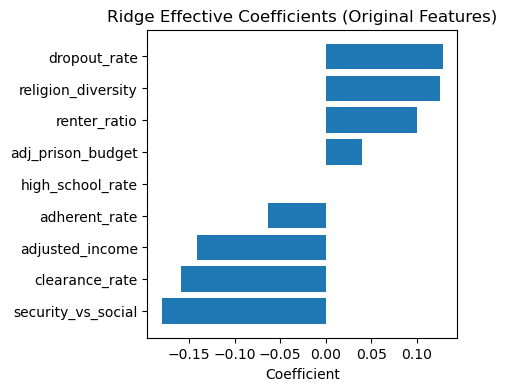

The top 4 important features in ridge are:
security_vs_social
clearance_rate
adjusted_income
dropout_rate


In [109]:
key="dropna"     # Can be 'dropna' or 'imputed'
key1="Urban"     # Can be 'Urban', 'Suburban', or 'Rural'
key2='reg'        # Can be 'reg' or 'Poly'
print(key+" "+key1+' '+key2+" log linear model")

Xtest=Xdt['test'][(key,key1,key2)]
Xtrain=Xdt['train'][(key,key1,key2)]
ytest=ydt['test'][(key,key1)]
ytrain=ydt['train'][(key,key1)]

n_components = 8
alpha=20
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
#Best_features[key1]=list(remove_features(set(Xtrain.columns), Xtrain, np.log(ytrain), models["ridge"], threshold=threshold_removal,min_features=n_components))

ff=Best_features[key1]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[key1], models_stats, models_pred = log_fit(Xtrain[ff],Xtest[ff], ytrain,ytest, **models)
urb_train=Xtrain.copy()
urb_train["error"]=ytrain-models_pred['ridge']['train']
urb_train['crime_rate']=ytrain
urb_train['pred']=models_pred['ridge']['train']

urb_test=Xtest.copy()
urb_test["error"]=ytest-models_pred['ridge']['test']
urb_test['crime_rate']=ytest
urb_test['pred']=models_pred['ridge']['test']

# Using pretty table
print_table(models_stats)
feature_importance_PCA(fitted_models[key1],ff,(4,4), plot=True, models_to_use=['ridge'])

In [110]:
print_mse_mr2(models_stats)

╔═══════╦══════════════╦════════════════════════╦════════════════════╗
║ Model ║     Type     ║          MSE           ║        MR2         ║
╠═══════╬══════════════╬════════════════════════╬════════════════════╣
║ ridge ║  Reg train   ║ 6.394766464749542e-07  ║ 0.8297497349280686 ║
║       ║   Reg val    ║ 7.241765287692242e-07  ║ 0.825614088429796  ║
║       ║ County train ║ 6.087137264289414e-07  ║ 0.8351574335910459 ║
║       ║  County val  ║ 8.185807957824113e-07  ║ 0.7175272572112615 ║
║       ║  Time train  ║ 5.290472022998657e-07  ║ 0.8495139146143015 ║
║       ║   Time val   ║ 1.3650382926719547e-06 ║ 0.691964027584281  ║
║       ║     Test     ║ 5.397108884719842e-07  ║ 0.8161354855674486 ║
║       ║              ║                        ║                    ║
╚═══════╩══════════════╩════════════════════════╩════════════════════╝


# Suburban Model

imputed Suburban Poly log linear model
Optimal subset of features:
19 ['adherent_rate^2', 'adj_police_budget dropout_rate', 'population_density adj_welfare_budget', 'poverty_rate adj_rehab_budget', 'adjusted_income Median_Age', 'home_ownership_rate^2', 'mobile_home_ratio^2', 'Population', 'adj_rehab_budget', 'house_affordability', 'population_density poverty_rate', 'poverty_rate adj_police_budget', 'adherent_rate', 'adj_judiciary_budget', 'clearance_rate rent_burden', 'adjusted_income^2', 'public_school_rate^2', 'high_school_rate', 'public_school_rate']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦══════════════════════╦═════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score       ║         MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬══════════════════════╬═════════════════════╣
║ ridge ║  Reg train   ║ 1.6565903791756821e-06 ║ 0.0012870321763284302 ║ 0.4866015

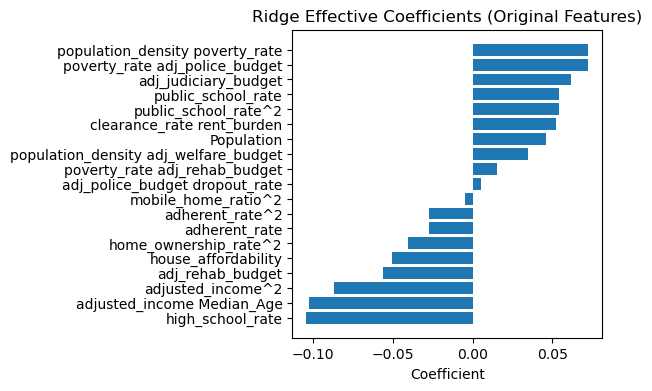

The top 4 important features in ridge are:
high_school_rate
adjusted_income Median_Age
adjusted_income^2
population_density poverty_rate


In [23]:
key="imputed"
key1="Suburban"
key2='Poly'
print(key+" "+key1+' '+key2+" log linear model")

Xtest=Xdt['test'][(key,key1,key2)]
Xtrain=Xdt['train'][(key,key1,key2)]
ytest=ydt['test'][(key,key1)]
ytrain=ydt['train'][(key,key1)]

n_components = 6
alpha=100
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
#Best_features[key1]=list(Poly_feature_selection(set(Xtrain.columns), Xtrain, np.log(ytrain), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components,dd=60))

ff=Best_features[key1]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[key1], models_stats, models_pred = log_fit(Xtrain[ff],Xtest[ff], ytrain,ytest, **models)
sub_train=Xtrain.copy()
sub_train["error"]=ytrain-models_pred['ridge']['train']
sub_train['crime_rate']=ytrain
sub_train['pred']=models_pred['ridge']['train']

sub_test=Xtest.copy()
sub_test["error"]=ytest-models_pred['ridge']['test']
sub_test['crime_rate']=ytest
sub_test['pred']=models_pred['ridge']['test']

# Using pretty table
print_table(models_stats)
feature_importance_PCA(fitted_models[key1],ff,(4,4), plot=True, models_to_use=['ridge'])

# Rural Model

dropna Rural Poly log linear model
Optimal subset of features:
19 ['adjusted_income adherent_rate', 'adj_mental_health_budget uninsured_rate', 'adjusted_income', 'mobile_home_ratio', 'clearance_rate', 'vacancy_rate security_vs_social', 'rent_burden adherent_rate', 'dropout_rate', 'security_vs_social religion_diversity', 'adj_health_budget uninsured_rate', 'uninsured_rate', 'renter_ratio adherent_rate', 'adj_judiciary_budget adherent_rate', 'poverty_rate Number_of_Persons_per_HseHld', 'home_ownership_rate adj_health_budget', 'adj_judiciary_budget high_school_rate', 'population_density', 'adj_prison_budget uninsured_rate', 'adj_education_budget']
╔═══════╦══════════════╦════════════════════════╦═══════════════════════╦═════════════════════╦═════════════════════╗
║ Model ║     Type     ║          MSE           ║          RMSE         ║       r2 Score      ║         MR2         ║
╠═══════╬══════════════╬════════════════════════╬═══════════════════════╬═════════════════════╬════════════════

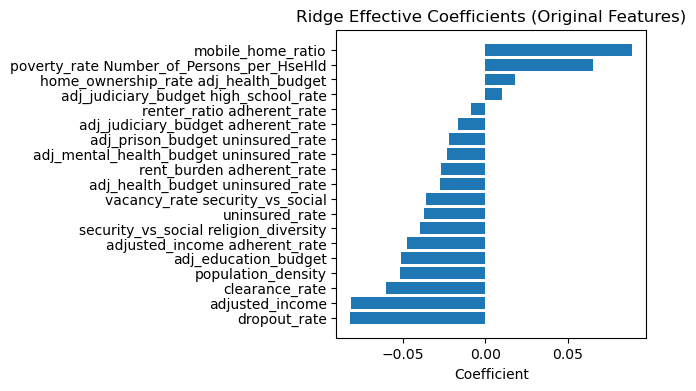

The top 4 important features in ridge are:
mobile_home_ratio
dropout_rate
adjusted_income
poverty_rate Number_of_Persons_per_HseHld


In [24]:
key="dropna"
key1="Rural"
key2='Poly'
print(key+" "+key1+' '+key2+" log linear model")

Xtest=Xdt['test'][(key,key1,key2)]
Xtrain=Xdt['train'][(key,key1,key2)]
ytest=ydt['test'][(key,key1)]
ytrain=ydt['train'][(key,key1)]

n_components = 7
alpha=50
models = {
    #"mlr": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("Lin", LinearRegression())]),
    #"xgb": xgb.XGBRegressor(random_state=42,max_depth=3, n_estimators=100),
    "ridge": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components,whiten=True)), ("ridge", Ridge(alpha))]),
    #"random_forest": Pipeline([("scale", StandardScaler()),('pca',PCA(n_components=n_components)), ("randomforest", RandomForestRegressor())]),
}

threshold_addition=0.002
threshold_removal=0.002
#Uncomment this to perform feature selection again
#Best_features[key1]=list(Poly_feature_selection(set(Xtrain.columns), Xtrain, np.log(ytrain), models["ridge"], threshold_addition=threshold_addition, threshold_removal=threshold_removal,min_features=n_components,dd=60))

ff=Best_features[key1]
print("Optimal subset of features:")
print(len(ff),ff)


fitted_models[key1], models_stats, models_pred = log_fit(Xtrain[ff],Xtest[ff], ytrain,ytest, **models)

rur_train=Xtrain.copy()
rur_train["error"]=ytrain-models_pred['ridge']['train']
rur_train['crime_rate']=ytrain
rur_train['pred']=models_pred['ridge']['train']

rur_test=Xtest.copy()
rur_test["error"]=ytest-models_pred['ridge']['test']
rur_test['crime_rate']=ytest
rur_test['pred']=models_pred['ridge']['test']

# Using pretty table
print_table(models_stats)
feature_importance_PCA(fitted_models[key1],ff,(4,4), plot=True, models_to_use=['ridge'])



# Residual Plots

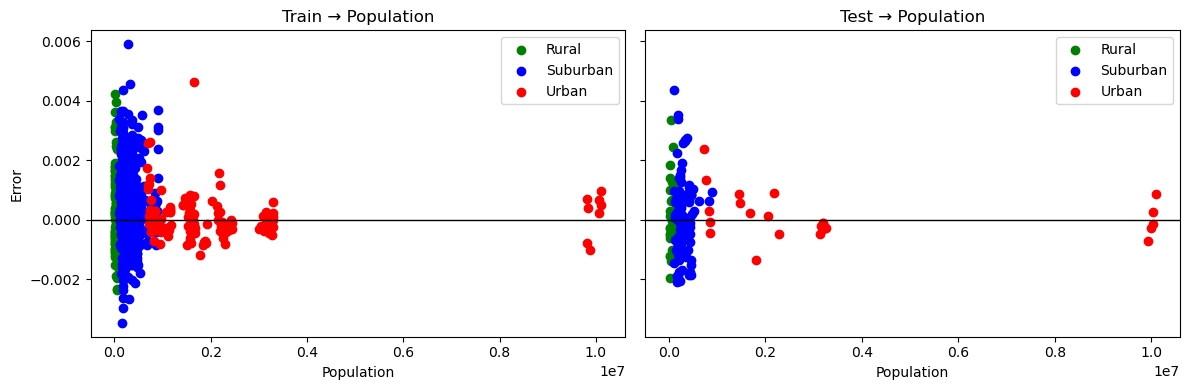

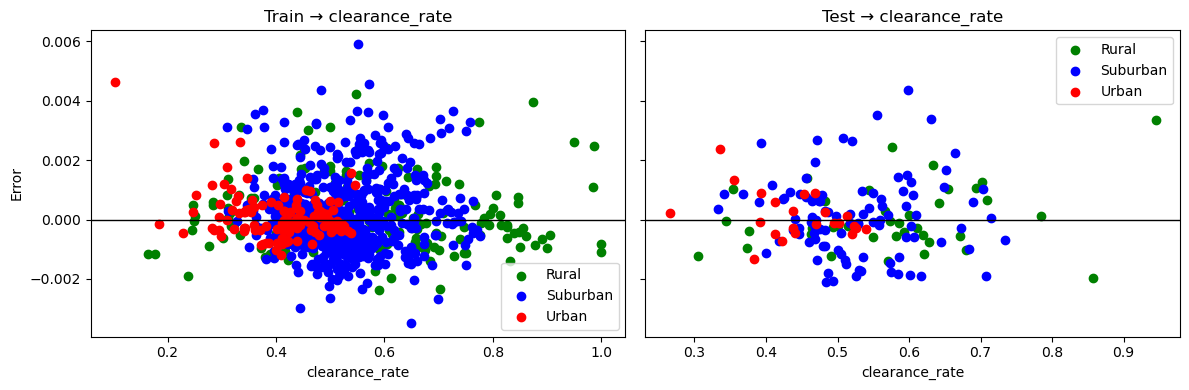

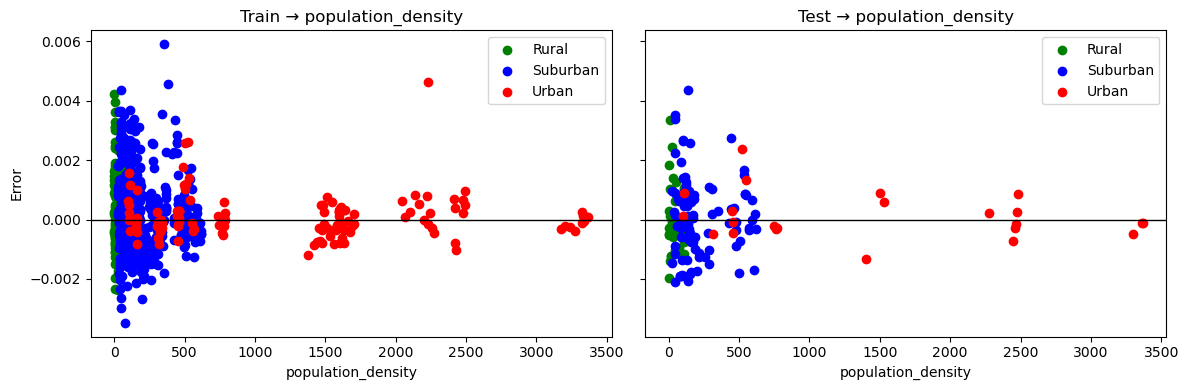

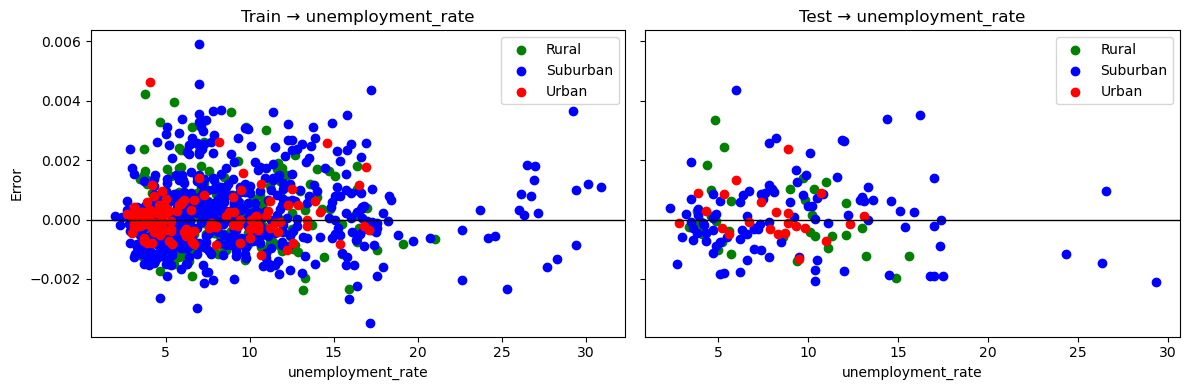

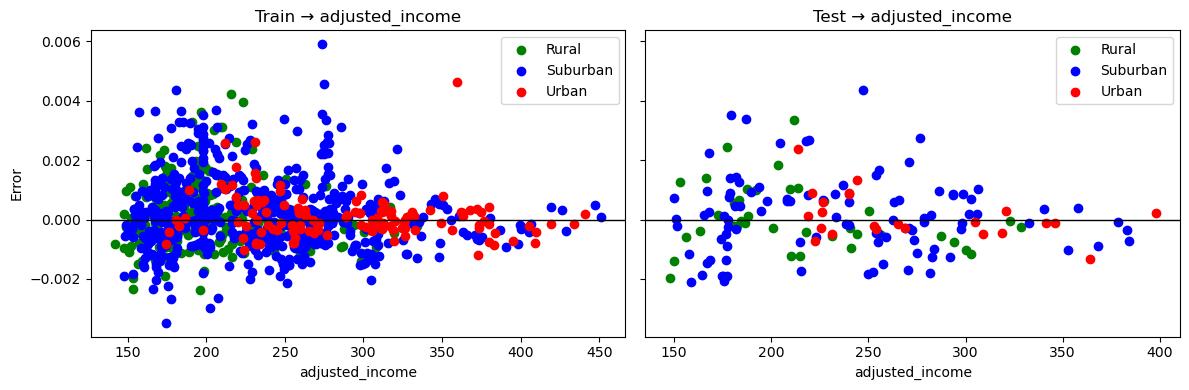

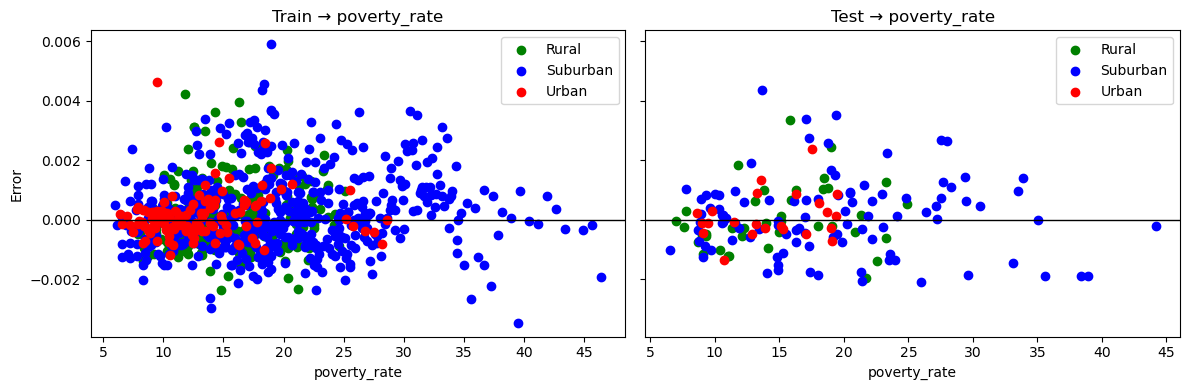

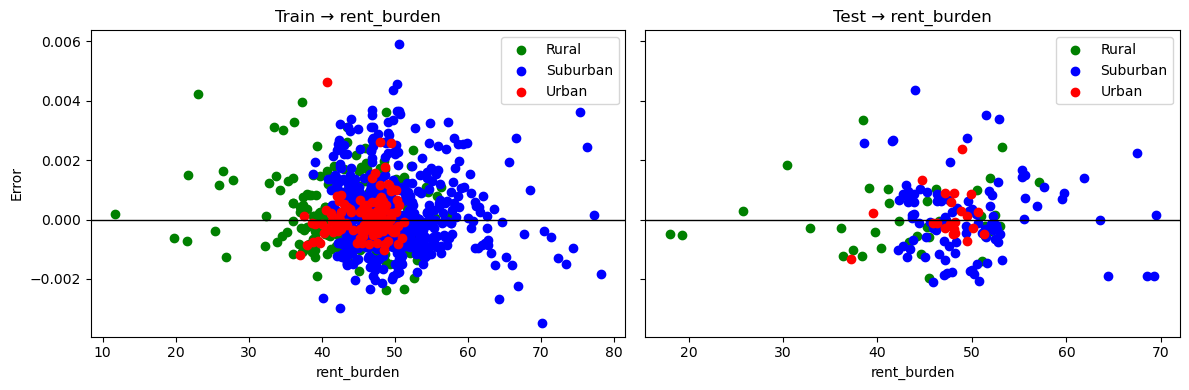

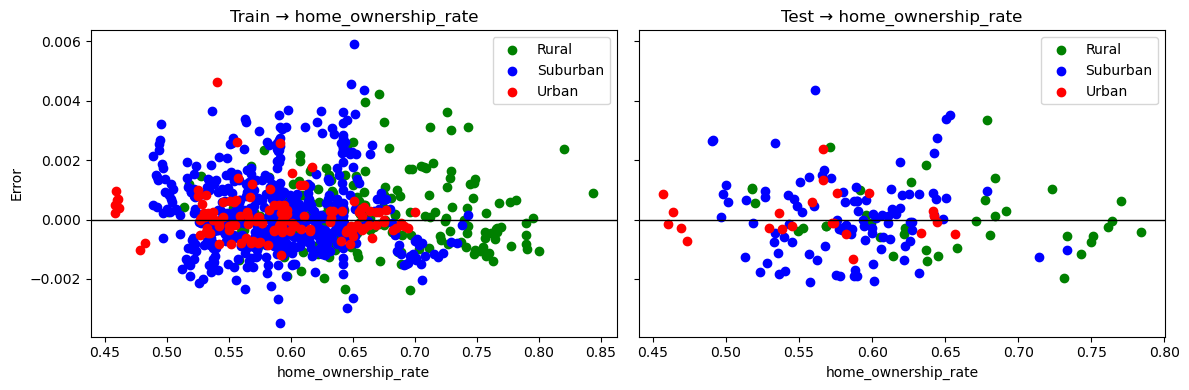

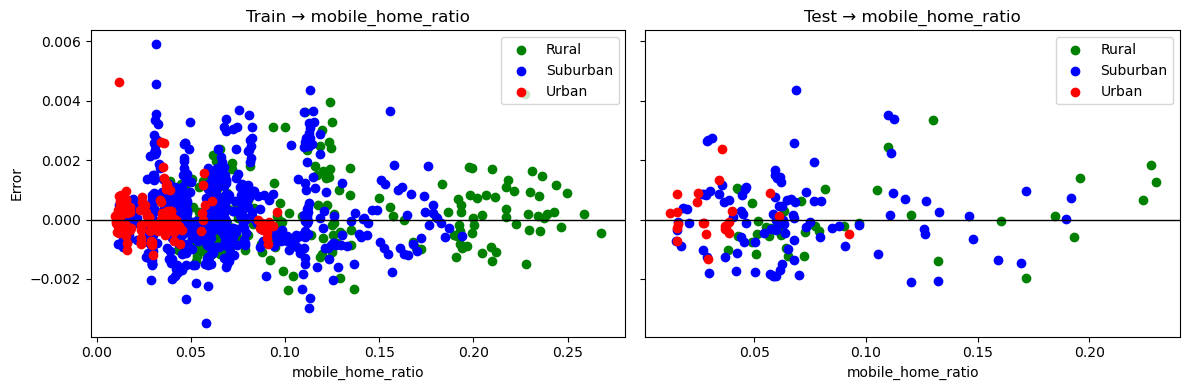

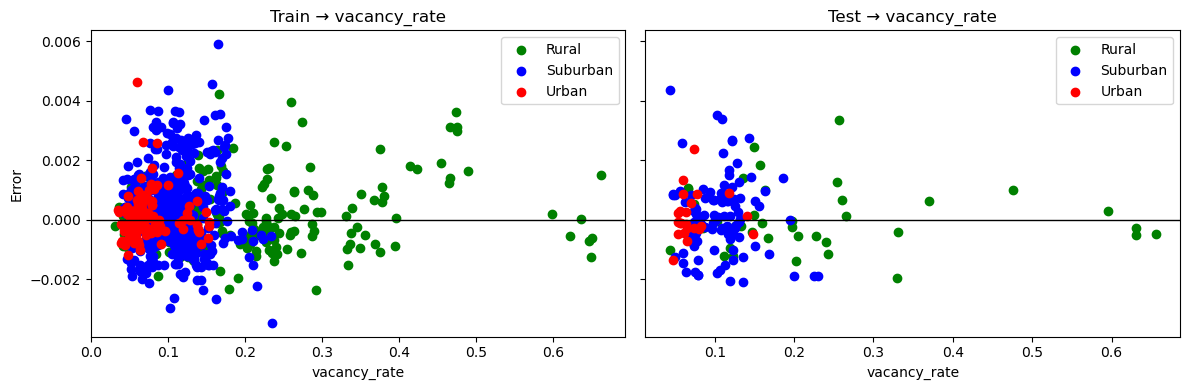

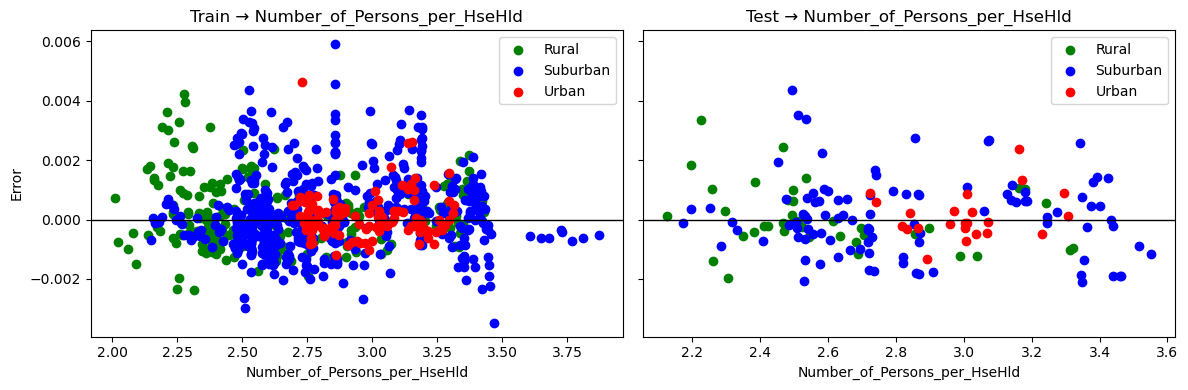

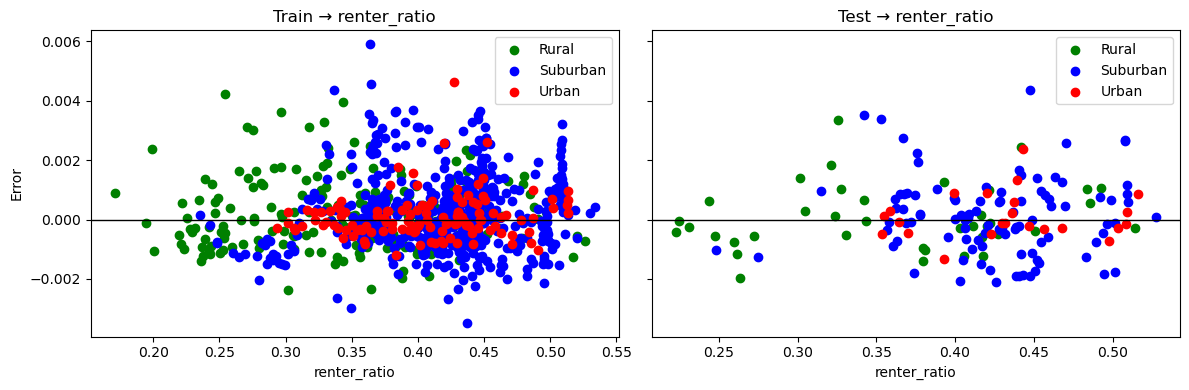

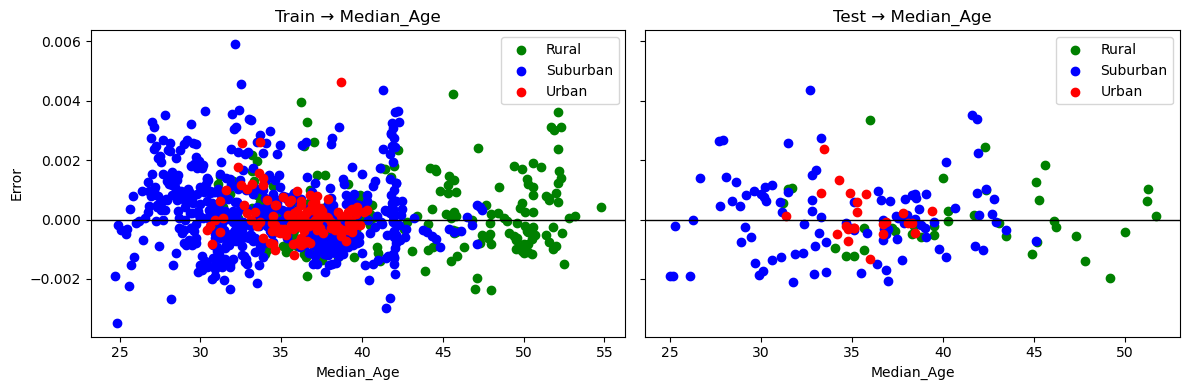

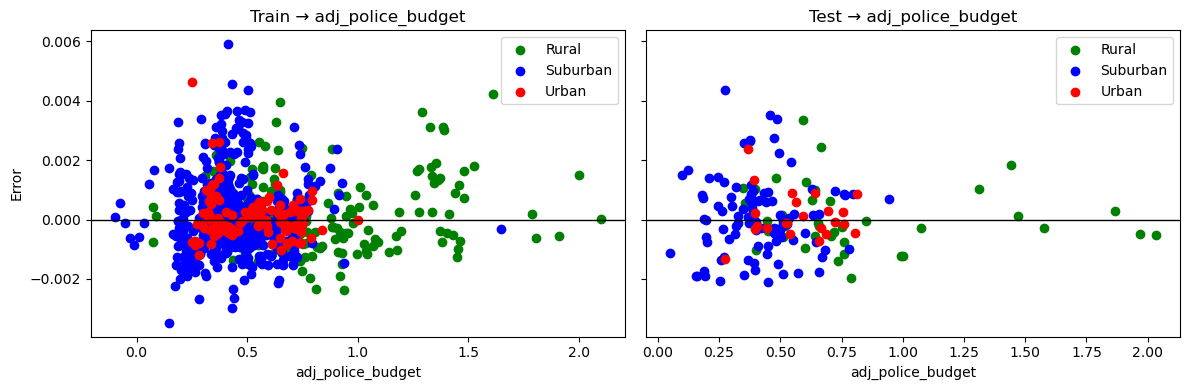

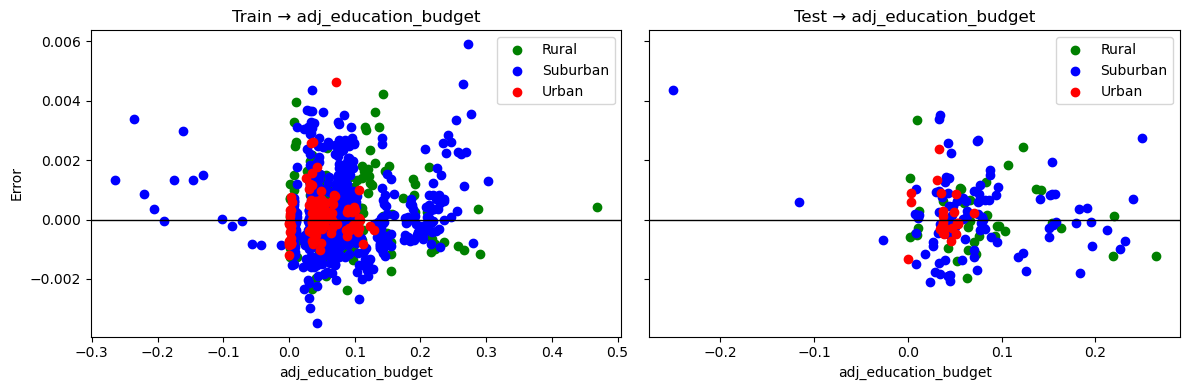

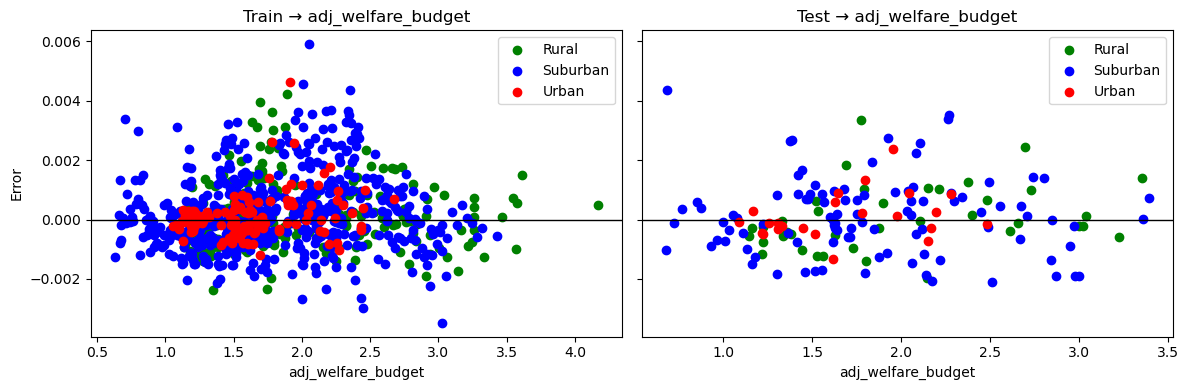

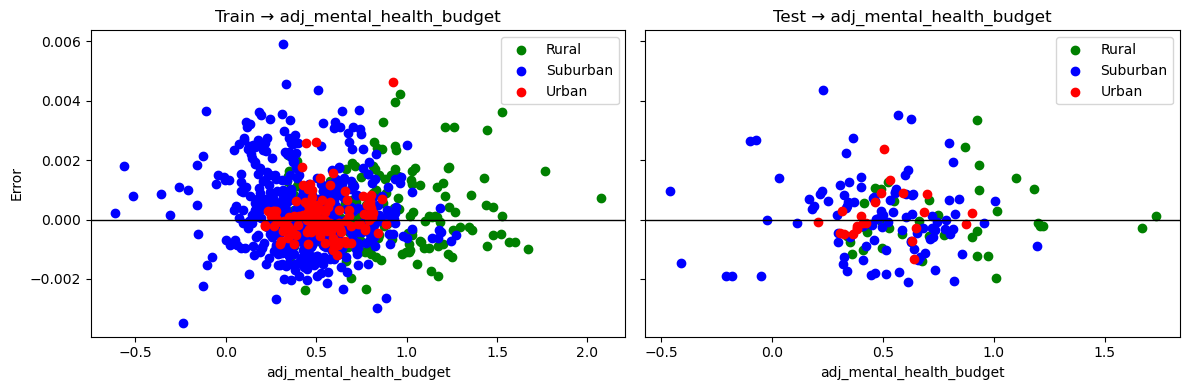

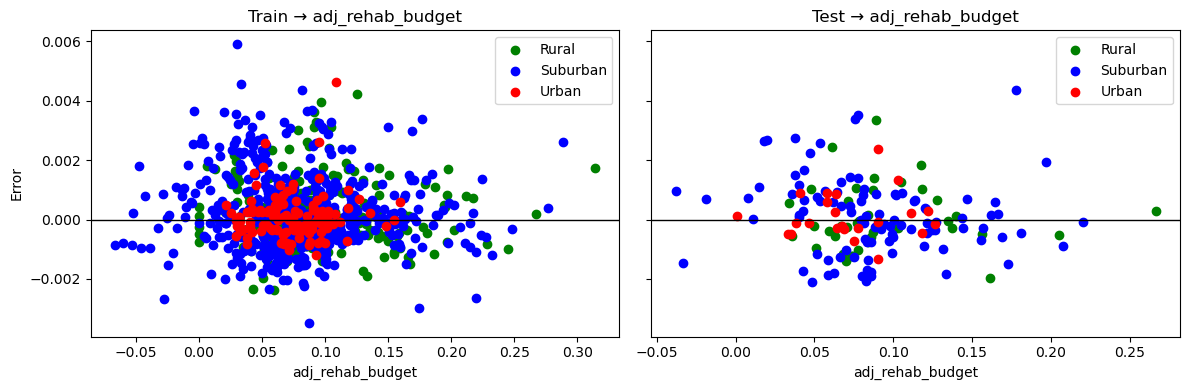

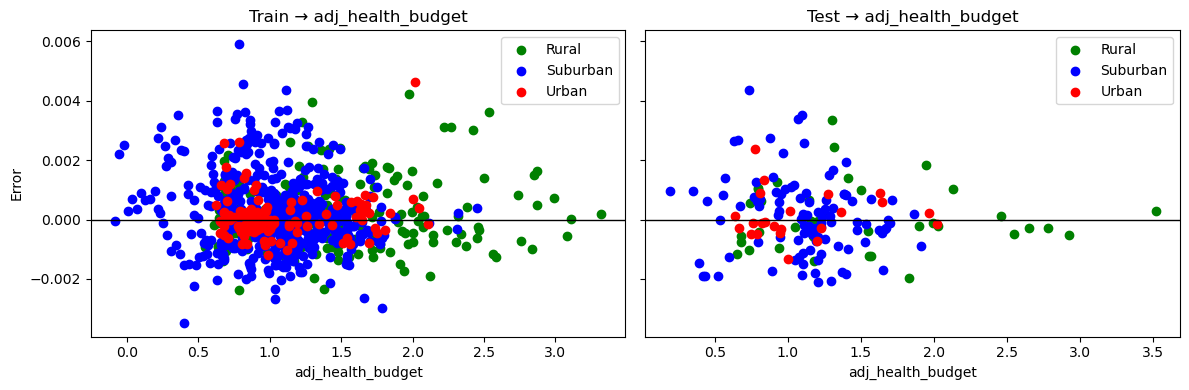

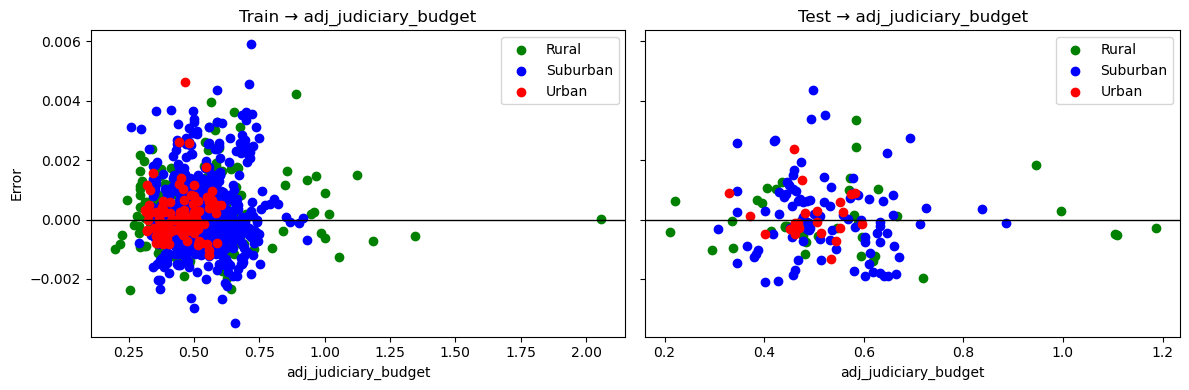

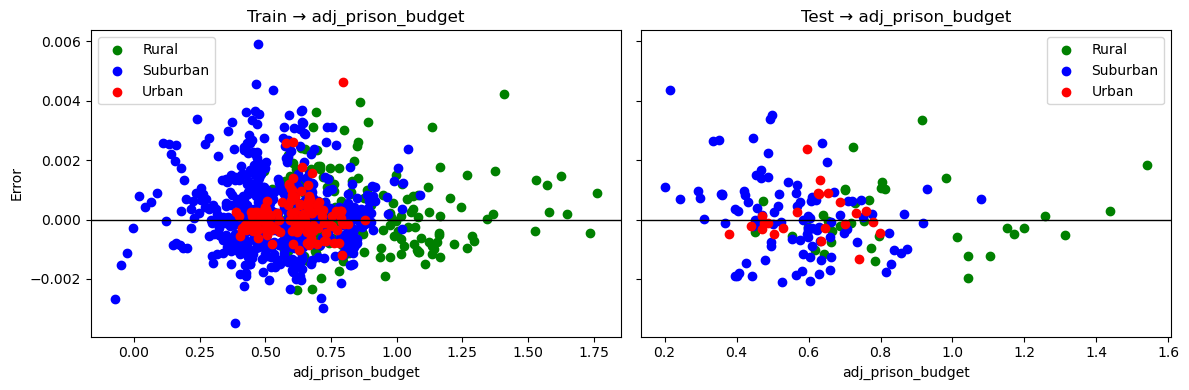

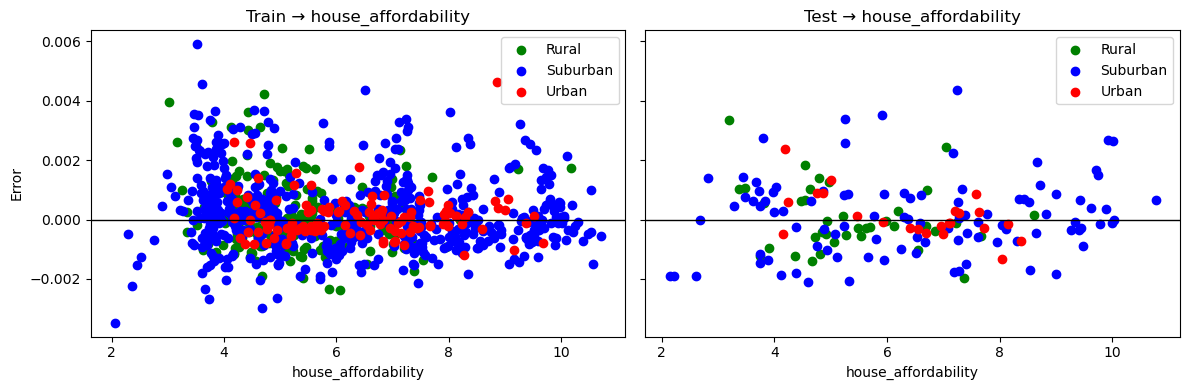

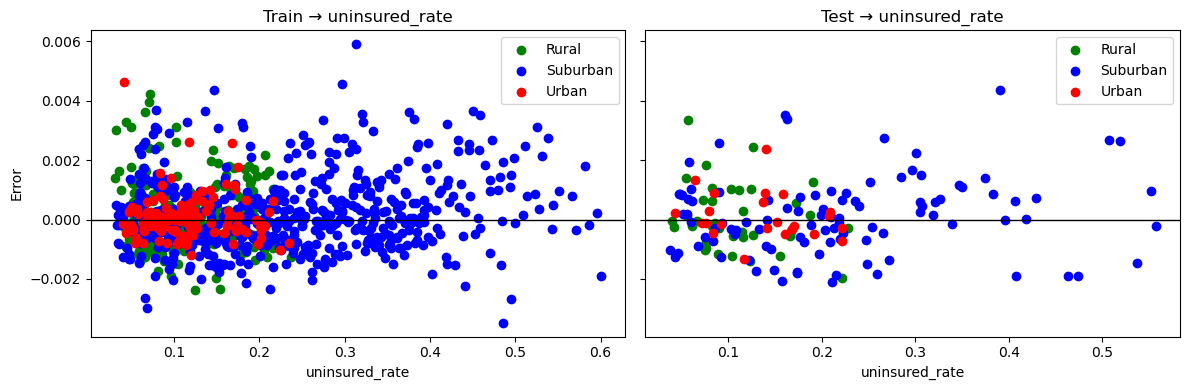

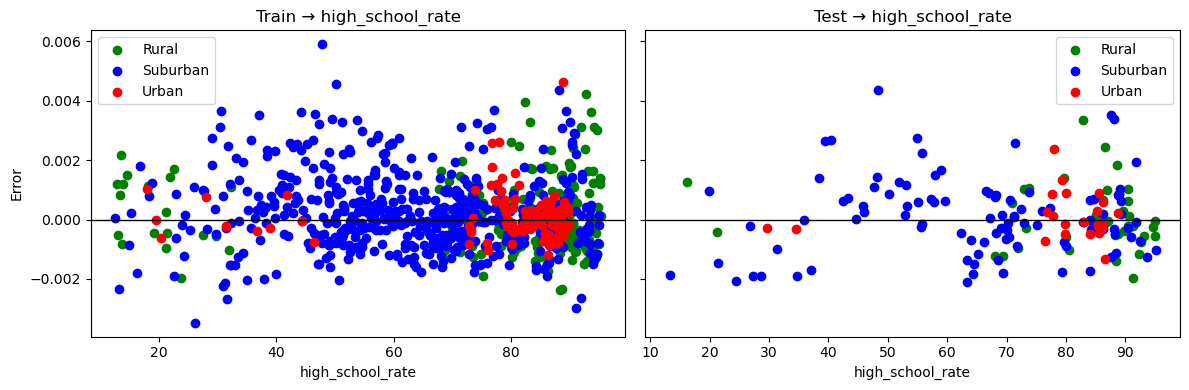

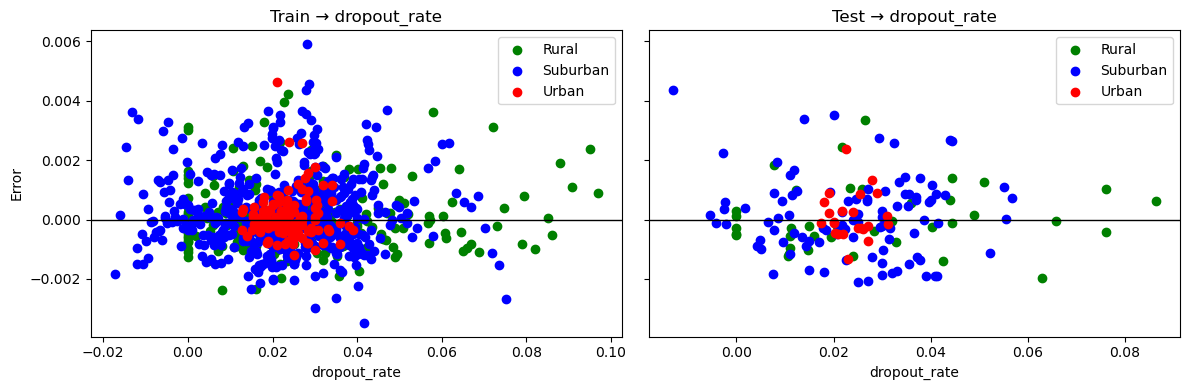

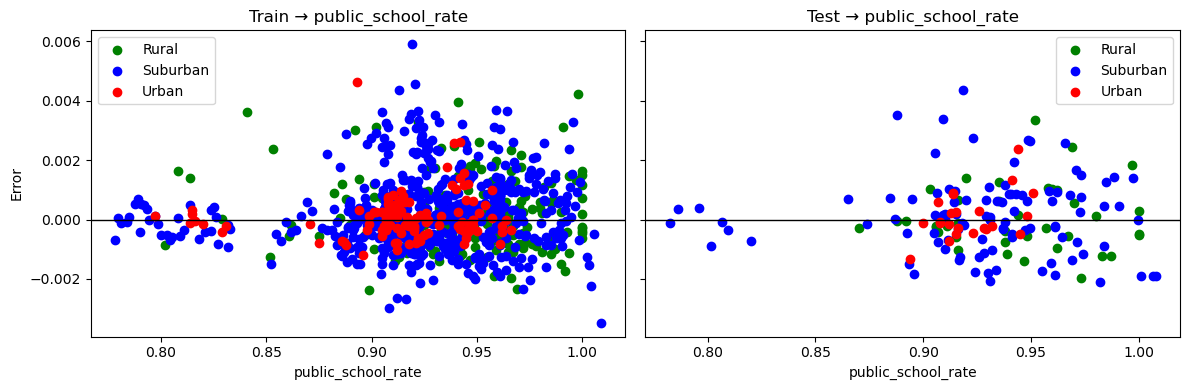

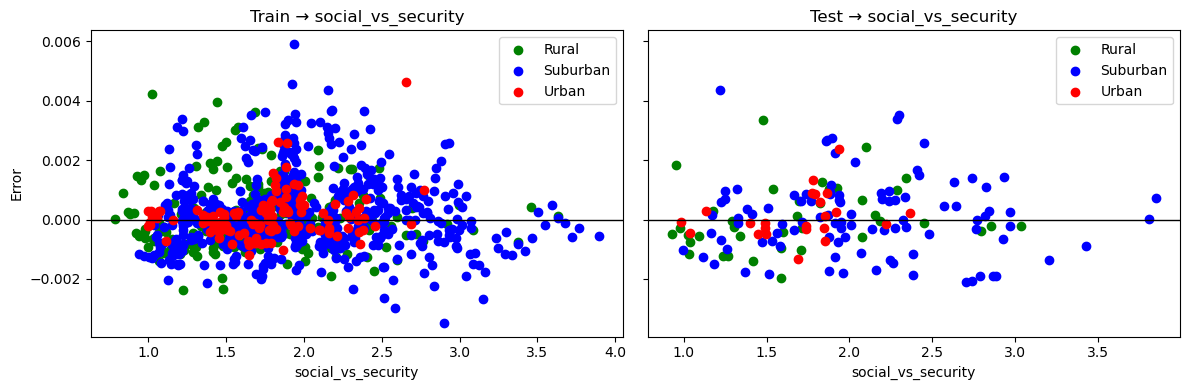

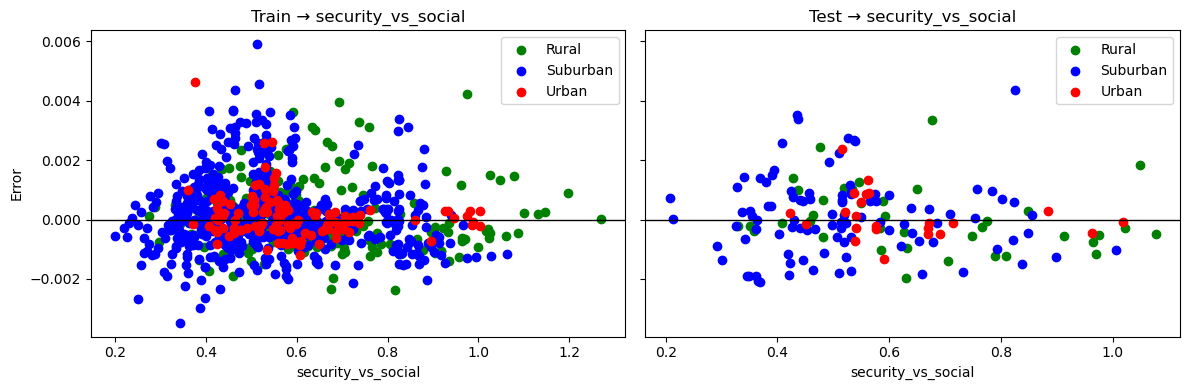

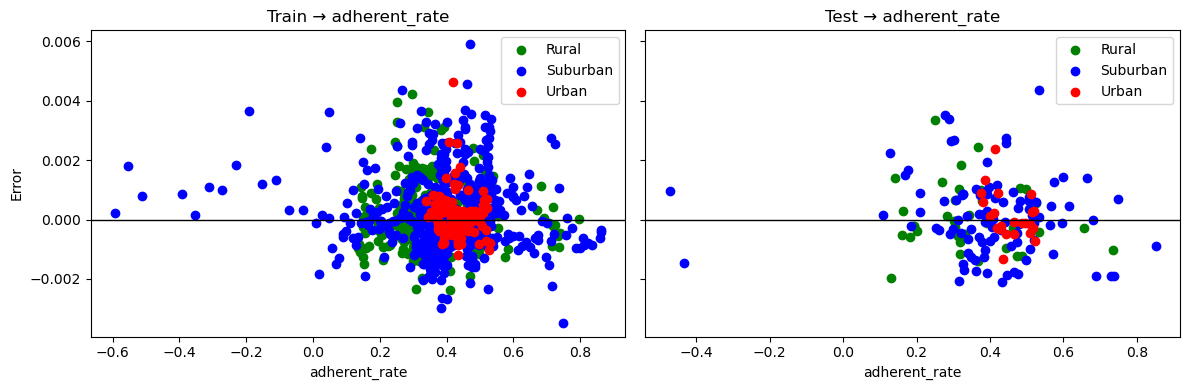

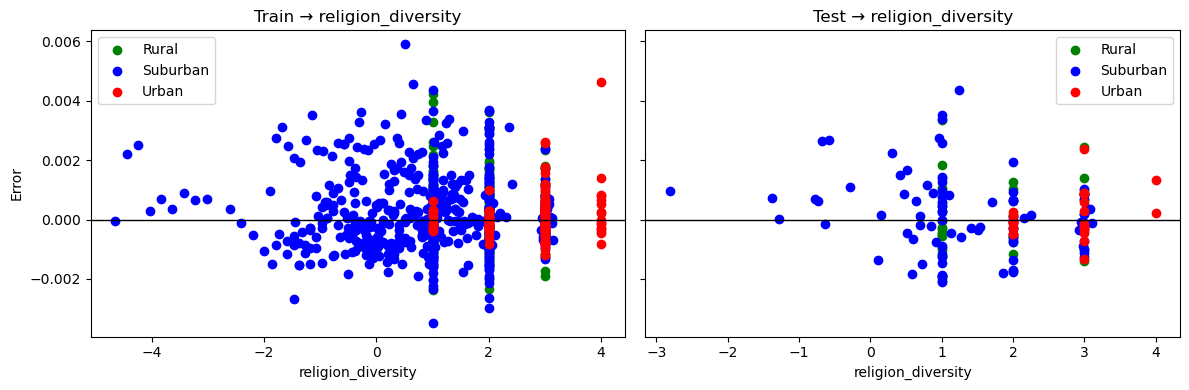

In [25]:
import matplotlib.pyplot as plt

for xx in feature_0:
    # Create a 1×2 grid for train vs test
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # ---- Left: training data ----
    ax = axes[0]
    ax.axhline(y=0, color='black', linewidth=1)
    ax.scatter(rur_train[xx], rur_train["error"], c='green', label='Rural')
    ax.scatter(sub_train[xx], sub_train["error"], c='blue',  label='Suburban')
    ax.scatter(urb_train[xx], urb_train["error"], c='red',   label='Urban')
    ax.set_title(f'Train → {xx}')
    ax.set_xlabel(xx)
    ax.set_ylabel('Error')
    ax.legend()

    # ---- Right: test data ----
    ax = axes[1]
    ax.axhline(y=0, color='black', linewidth=1)
    ax.scatter(rur_test[xx],  rur_test["error"],  c='green', label='Rural')
    ax.scatter(sub_test[xx],  sub_test["error"],  c='blue',  label='Suburban')
    ax.scatter(urb_test[xx],  urb_test["error"],  c='red',   label='Urban')
    ax.set_title(f'Test → {xx}')
    ax.set_xlabel(xx)
    # no need to set ylabel again since sharey=True

    ax.legend()

    plt.tight_layout()
    plt.show()


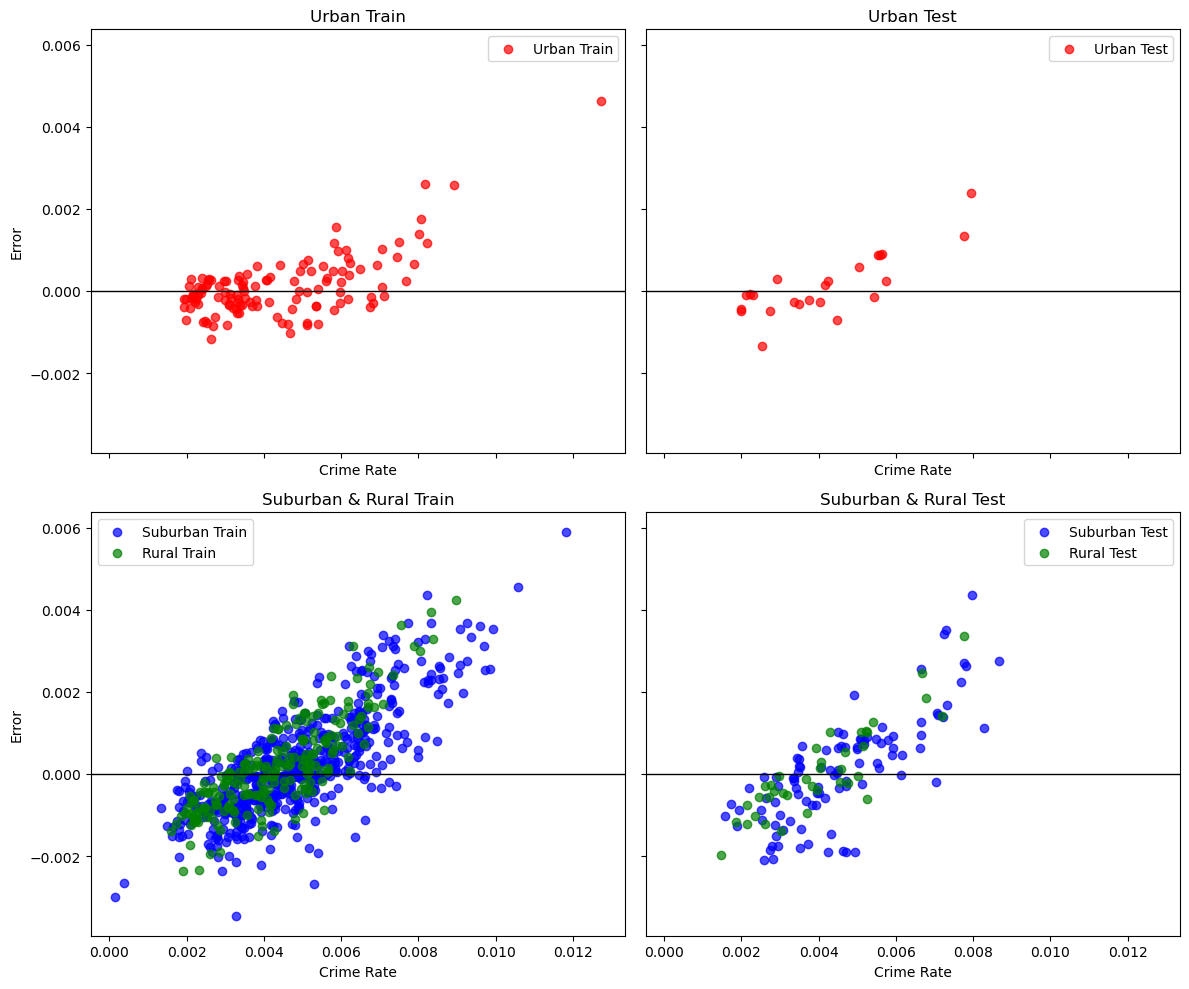

In [26]:
import matplotlib.pyplot as plt

# Create a 2×2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Top-left: Urban train
ax = axs[0, 0]
ax.axhline(0, color='black', linewidth=1)
ax.scatter(urb_train['crime_rate'], urb_train['error'], c='red',   alpha=0.7, label='Urban Train')
ax.set_title('Urban Train')
ax.set_xlabel('Crime Rate')
ax.set_ylabel('Error')
ax.legend()

# Top-right: Urban test
ax = axs[0, 1]
ax.axhline(0, color='black', linewidth=1)
ax.scatter(urb_test['crime_rate'], urb_test['error'], c='red',   alpha=0.7, label='Urban Test')
ax.set_title('Urban Test')
ax.set_xlabel('Crime Rate')
ax.legend()

# Bottom-left: Suburban & Rural train
ax = axs[1, 0]
ax.axhline(0, color='black', linewidth=1)
ax.scatter(sub_train['crime_rate'], sub_train['error'], c='blue',  alpha=0.7, label='Suburban Train')
ax.scatter(rur_train['crime_rate'], rur_train['error'], c='green', alpha=0.7, label='Rural Train')
ax.set_title('Suburban & Rural Train')
ax.set_xlabel('Crime Rate')
ax.set_ylabel('Error')
ax.legend()

# Bottom-right: Suburban & Rural test
ax = axs[1, 1]
ax.axhline(0, color='black', linewidth=1)
ax.scatter(sub_test['crime_rate'], sub_test['error'], c='blue',  alpha=0.7, label='Suburban Test')
ax.scatter(rur_test['crime_rate'], rur_test['error'], c='green', alpha=0.7, label='Rural Test')
ax.set_title('Suburban & Rural Test')
ax.set_xlabel('Crime Rate')
ax.legend()

plt.tight_layout()
plt.show()


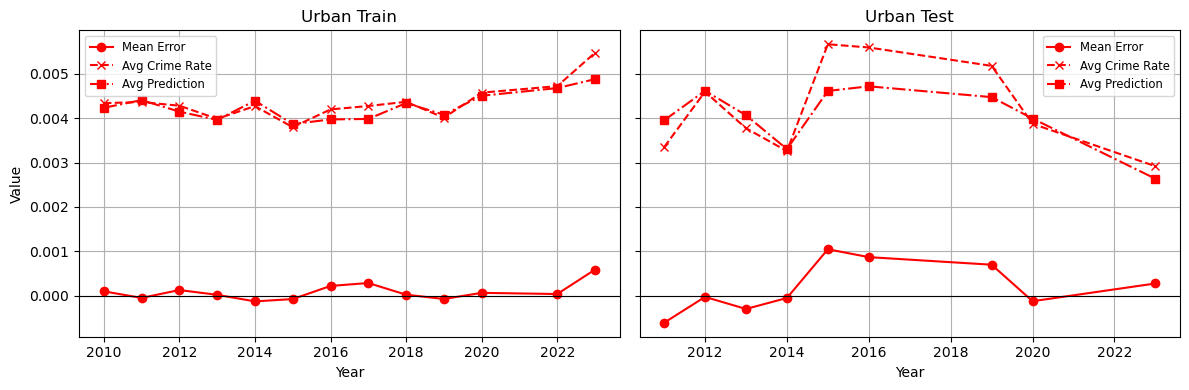

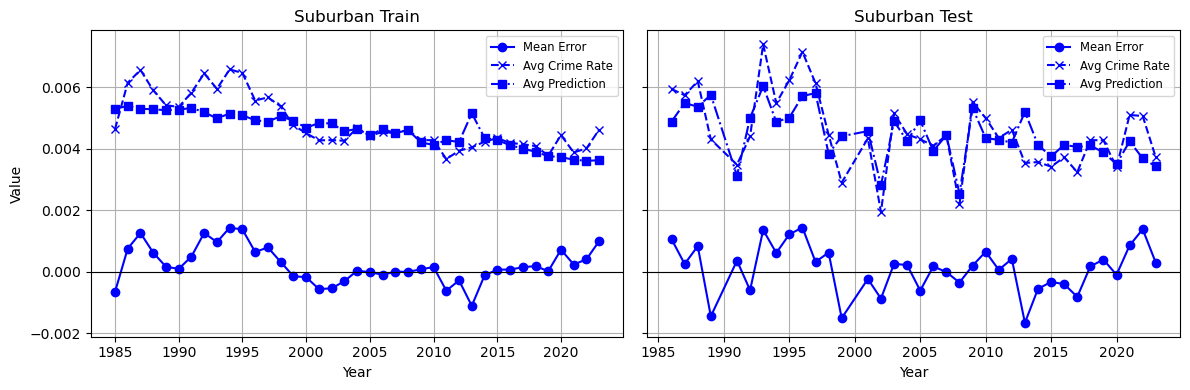

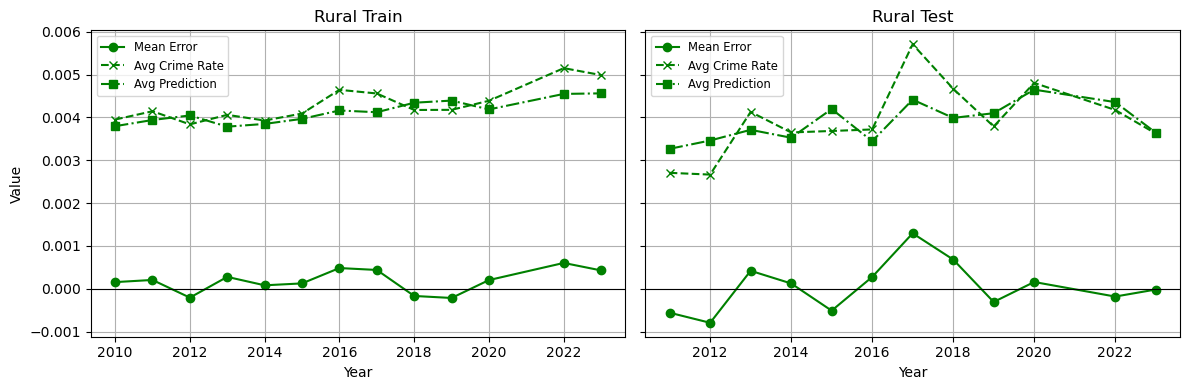

In [27]:
import matplotlib.pyplot as plt

# Define the three categories and their train/test dataframes
categories = [
    ('Urban',   urb_train,   urb_test),
    ('Suburban', sub_train,  sub_test),
    ('Rural',    rur_train,  rur_test)
]
colors = {'Urban':'red','Suburban':'blue','Rural':'green'}

for label, df_train, df_test in categories:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    for ax, (split_name, df) in zip(axes, [('Train', df_train), ('Test', df_test)]):
        tmp = df.reset_index()
        tmp['Year'] = tmp['Year'].astype(int)
        
        # mean error by year
        yearly_err = tmp.groupby('Year')['error'].mean()
        ax.plot(
            yearly_err.index, yearly_err.values,
            marker='o', linestyle='-',
            color=colors[label],
            label='Mean Error'
        )
        
        # mean crime_rate by year
        yearly_crime = tmp.groupby('Year')['crime_rate'].mean()
        ax.plot(
            yearly_crime.index, yearly_crime.values,
            marker='x', linestyle='--',
            color=colors[label],
            label='Avg Crime Rate'
        )
        
        # mean prediction by year
        yearly_pred = tmp.groupby('Year')['pred'].mean()
        ax.plot(
            yearly_pred.index, yearly_pred.values,
            marker='s', linestyle='-.',
            color=colors[label],
            label='Avg Prediction'
        )
        
        ax.set_title(f'{label} {split_name}')
        ax.set_xlabel('Year')
        if split_name == 'Train':
            ax.set_ylabel('Value')
        ax.axhline(0, color='black', linewidth=0.8)
        ax.legend(fontsize='small')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


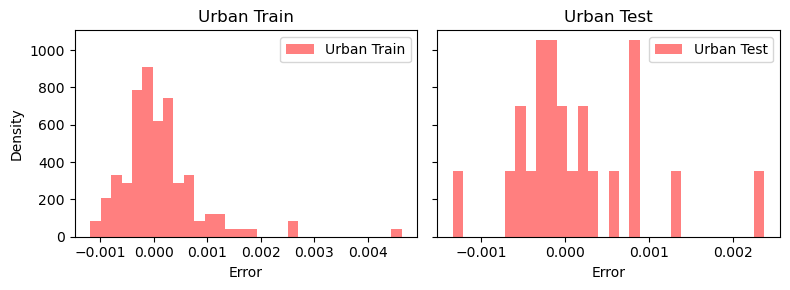

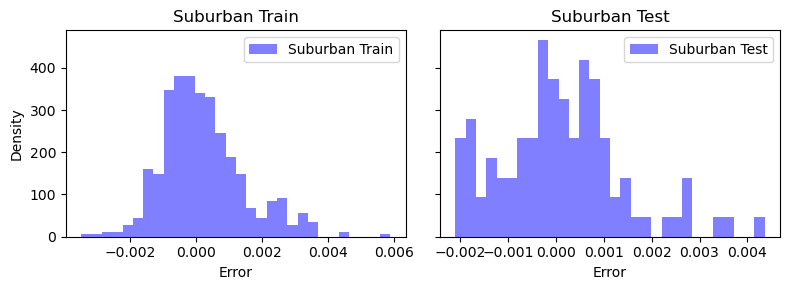

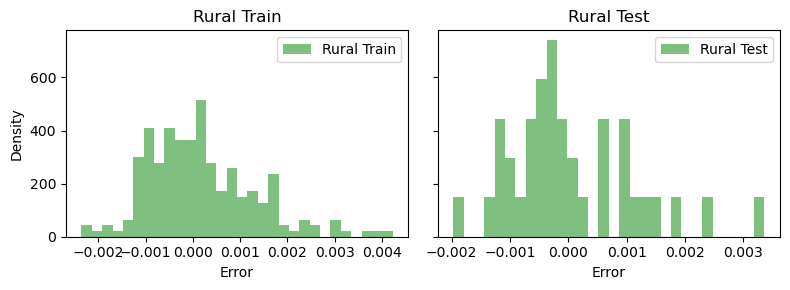

In [28]:
import matplotlib.pyplot as plt

# Define the train/test splits and colors for each category
splits = [
    ("Urban",    urb_train,    urb_test,    "red"),
    ("Suburban", sub_train,    sub_test,    "blue"),
    ("Rural",    rur_train,    rur_test,    "green")
]

for label, df_train, df_test, color in splits:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

    # Train histogram on the left
    axes[0].hist(
        df_train["error"],
        bins=30,
        density=True,
        alpha=0.5,
        color=color,
        label=f"{label} Train"
    )
    axes[0].set_title(f"{label} Train")
    axes[0].set_xlabel("Error")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    # Test histogram on the right
    axes[1].hist(
        df_test["error"],
        bins=30,
        density=True,
        alpha=0.5,
        color=color,
        label=f"{label} Test"
    )
    axes[1].set_title(f"{label} Test")
    axes[1].set_xlabel("Error")
    # only left subplot needs a y-label
    axes[1].legend()

    plt.tight_layout()
    plt.show()


# Why is the rural model worse than the urban model?

In [29]:
urb = pd.concat([urb_train, urb_test])
sub = pd.concat([sub_train, sub_test])
rur = pd.concat([rur_train, rur_test])

average is std of clearance_rate in Urban counties 0.03001927949311493
average is std of clearance_rate in Suburban counties 0.07222465876027392
average is std of clearance_rate in Rural counties 0.12133088185263657


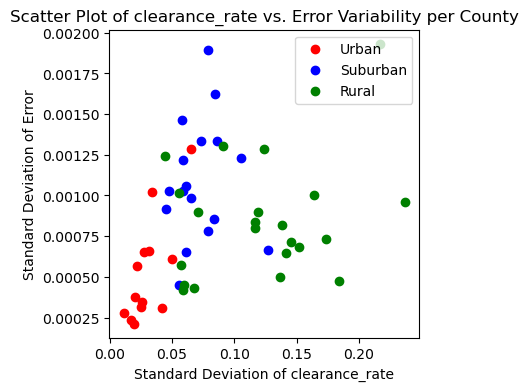

In [30]:
xx='clearance_rate'
print(f'average is std of {xx} in Urban counties' ,urb.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Suburban counties',sub.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Rural counties',rur.groupby("County")[xx].std().mean())


urb_std = urb.groupby(level='County')[[xx, 'error']].std()
sub_std = sub.groupby(level='County')[[xx, 'error']].std()
rur_std = rur.groupby(level='County')[[xx, 'error']].std()

# Create a scatter plot: x-axis is std of clearance_rate and y-axis is std of error
plt.figure(figsize=(4, 4))
plt.scatter(urb_std[xx], urb_std['error'], c='red', label='Urban')
plt.scatter(sub_std[xx], sub_std['error'], c='blue', label='Suburban')
plt.scatter(rur_std[xx], rur_std['error'], c='green', label='Rural')
plt.legend()
plt.xlabel(f'Standard Deviation of {xx}')
plt.ylabel('Standard Deviation of Error')
plt.title(f'Scatter Plot of {xx} vs. Error Variability per County')
plt.show()

average is std of security_vs_social in Urban counties 0.03395649755204785
average is std of security_vs_social in Suburban counties 0.04905511155781934
average is std of security_vs_social in Rural counties 0.062048221179217315


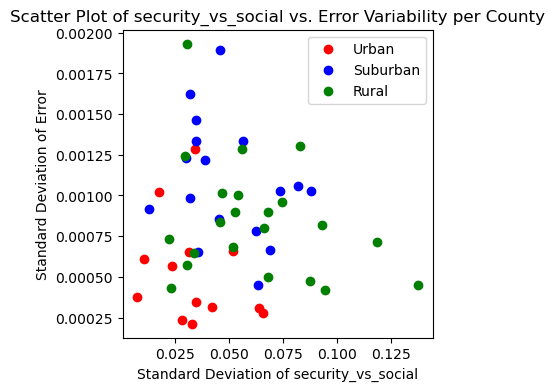

In [31]:
xx='security_vs_social'
print(f'average is std of {xx} in Urban counties' ,urb.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Suburban counties',sub.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Rural counties',rur.groupby("County")[xx].std().mean())


urb_std = urb.groupby(level='County')[[xx, 'error']].std()
sub_std = sub.groupby(level='County')[[xx, 'error']].std()
rur_std = rur.groupby(level='County')[[xx, 'error']].std()

# Create a scatter plot: x-axis is std of clearance_rate and y-axis is std of error
plt.figure(figsize=(4, 4))
plt.scatter(urb_std[xx], urb_std['error'], c='red', label='Urban')
plt.scatter(sub_std[xx], sub_std['error'], c='blue', label='Suburban')
plt.scatter(rur_std[xx], rur_std['error'], c='green', label='Rural')
plt.legend()
plt.xlabel(f'Standard Deviation of {xx}')
plt.ylabel('Standard Deviation of Error')
plt.title(f'Scatter Plot of {xx} vs. Error Variability per County')
plt.show()

average is std of dropout_rate in Urban counties 0.003567000951363562
average is std of dropout_rate in Suburban counties 0.009142227289164123
average is std of dropout_rate in Rural counties 0.014104226390950008


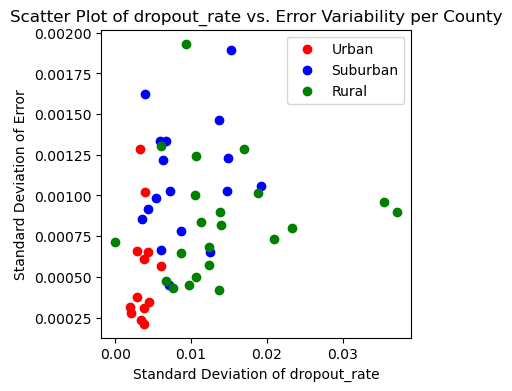

In [32]:
xx='dropout_rate'
print(f'average is std of {xx} in Urban counties' ,urb.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Suburban counties',sub.groupby("County")[xx].std().mean())
print(f'average is std of {xx} in Rural counties',rur.groupby("County")[xx].std().mean())


urb_std = urb.groupby(level='County')[[xx, 'error']].std()
sub_std = sub.groupby(level='County')[[xx, 'error']].std()
rur_std = rur.groupby(level='County')[[xx, 'error']].std()

# Create a scatter plot: x-axis is std of clearance_rate and y-axis is std of error
plt.figure(figsize=(4, 4))
plt.scatter(urb_std[xx], urb_std['error'], c='red', label='Urban')
plt.scatter(sub_std[xx], sub_std['error'], c='blue', label='Suburban')
plt.scatter(rur_std[xx], rur_std['error'], c='green', label='Rural')
plt.legend()
plt.xlabel(f'Standard Deviation of {xx}')
plt.ylabel('Standard Deviation of Error')
plt.title(f'Scatter Plot of {xx} vs. Error Variability per County')
plt.show()

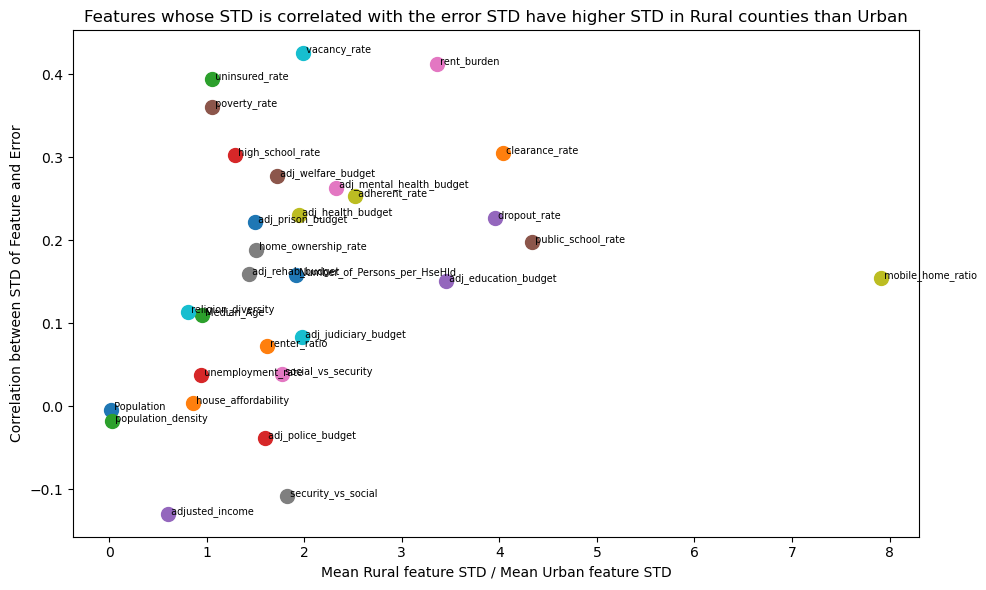

In [33]:
corr_dict = {}
ratio_dict = {}

for xx in feature_0:
    #print("\nFeature:", xx)
    
    # Compute standard deviations grouped by county for each dataset
    urb_std = urb.groupby(level='County')[[xx, 'error']].std()
    sub_std = sub.groupby(level='County')[[xx, 'error']].std()
    rur_std = rur.groupby(level='County')[[xx, 'error']].std()
    
    # Calculate the mean standard deviation of error for urban and rural counties
    mean_urb_error = urb.groupby("County")[xx].std().mean()
    mean_rur_error = rur.groupby("County")[xx].std().mean()
    
    # Compute the ratio: mean rural error std divided by mean urban error std
    ratio = mean_rur_error / mean_urb_error
    ratio_dict[xx] = ratio

    # Combine the standard deviations from all groups
    combined_std = pd.concat([urb_std, sub_std, rur_std])
    
    # Compute the Pearson correlation coefficient between the std of xx and error across all counties
    combined_corr = combined_std[xx].corr(combined_std['error'])
    corr_dict[xx] = combined_corr
    
    #print("Combined correlation:", combined_corr, "Error Ratio:", ratio)
    
    # Optional: Plot the scatter plot for each feature individually
    #plt.figure(figsize=(8, 6))
    #plt.scatter(urb_std[xx], urb_std['error'], c='red', label='Urban')
    #plt.scatter(sub_std[xx], sub_std['error'], c='blue', label='Suburban')
    #plt.scatter(rur_std[xx], rur_std['error'], c='green', label='Rural')
    #plt.xlabel(f'Standard Deviation of {xx}')
    #plt.ylabel('Standard Deviation of Error')
    #plt.title(f'Scatter Plot of {xx} vs. Error Variability per County')
    #plt.legend()
    #plt.show()

# Create a scatter plot: x-axis is the error ratio and y-axis is the correlation coefficient
plt.figure(figsize=(10, 6))
for xx in feature_0:
    x_val = ratio_dict[xx]
    y_val = corr_dict[xx]
    plt.scatter(x_val, y_val, s=100)  # s sets the marker size
    plt.text(x_val, y_val, f' {xx}', fontsize=7)  # Annotate each point with the feature name

plt.xlabel('Mean Rural feature STD / Mean Urban feature STD')
plt.ylabel('Correlation between STD of Feature and Error')
plt.title('Features whose STD is correlated with the error STD have higher STD in Rural counties than Urban')
plt.tight_layout()
plt.show()
